## Importing Libraries and IBM PAIRS Authentication

In [1]:
import pandas as pd
from ibmpairs import paw, authentication
import json
import numpy
from datetime import datetime, timedelta
import logging
import matplotlib.pyplot as plt
import re
import numpy as np

In [10]:
logging.basicConfig(level=logging.INFO)
pawLogger = logging.getLogger('ibmpairs.paw')
pawLogger.setLevel(logging.INFO)

In [11]:
with open("./pairs_api_key.txt", "r") as f:
    pairs_key = f.read()

In [12]:
pairs_credentials = authentication.OAuth2(api_key=pairs_key)
auth_header = {'Authorization': f'Bearer {pairs_credentials.jwt_token}'}
PAIRS_SERVER   = 'https://pairs.res.ibm.com'
PAIRS_CREDENTIALS = authentication.OAuth2(api_key=pairs_key)

In [13]:
iso8601 = '%Y-%m-%dT%H:%M:%SZ'

## Sentinel 2: Red, Green, Blue, NIR, NDVI
## 2015

## Some area in Bern, 08/2015 - 09/2015
Define layers, start & end date, region of interest

In [7]:
rgbNirNdviLayers = {
    'Red' : '49360',
    'Green' : '49681',
    'Blue' : '49680',
    'NIR': '49361',
    'NDVI' : '49464'
}

In [113]:
dates = {
    '20150801' : datetime(2015, 8, 1, 12).strftime(iso8601),
    '20150901' : datetime(2015, 9, 1, 12).strftime(iso8601)
}

In [114]:
query_bern_08_09_json = {
    'layers' : [
        {
            
            'type' : 'raster', 'id' : rgbNirNdviLayers[lKey],
            # 'temporal' : {'intervals' : [{'snapshot' : dates[dKey]}]},
            'temporal' : {'intervals' : [{'start' : list(dates.values())[0], 'end': list(dates.values())[1]}]},
            # 'output' : False
        }
        for lKey in rgbNirNdviLayers
    ],
    "spatial" : {"type" : "square",  "coordinates" : ["46.94599", "7.68597", "47.20599", "7.94597"] }, #Some area in Bern
    "temporal" : {"intervals" : [{ #this is redundant whne the temporal key is defined in layers! But still needed
        "start" : datetime(2015, 8, 1, 12).strftime(iso8601), "end" : datetime(2015, 9, 1, 12).strftime(iso8601)
        
    }
    ]}
}

In [115]:
query_bern_08_09 = paw.PAIRSQuery(query_bern_08_09_json, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query_bern_08_09.submit()

INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663214400_30482105


In [116]:
query_bern_08_09.poll_till_finished()
query_bern_08_09.download()
query_bern_08_09.create_layers()

INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663214400_30482105_580273818dc2cf672e3408645e013c15.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.


In [117]:
response_format = "%m_%d_%YT%H_%M_%S"
layers_08_09_df = pd.DataFrame([k.split("-") for k in query_bern_08_09.metadata], columns=["dataset", "band", "date"])
layers_08_09_df["pixelMin"] = [query_bern_08_09.metadata[k]["details"]["rasterStatistics"]["pixelMin"] for k in query_bern_08_09.metadata]
layers_08_09_df["pixelMax"] = [query_bern_08_09.metadata[k]["details"]["rasterStatistics"]["pixelMax"] for k in query_bern_08_09.metadata]
layers_08_09_df["layerKey"] = query_bern_08_09.metadata.keys()
layers_08_09_df["date"] = pd.to_datetime(layers_08_09_df["date"], format=response_format)
layers_08_09_df = layers_08_09_df.sort_values(by='date')
layers_08_09_df

dataset  \
4   High res  imagery (ESA Sentinel 2)   
5   High res  imagery (ESA Sentinel 2)   
20  High res  imagery (ESA Sentinel 2)   
8   High res  imagery (ESA Sentinel 2)   
17  High res  imagery (ESA Sentinel 2)   
29  High res  imagery (ESA Sentinel 2)   
21  High res  imagery (ESA Sentinel 2)   
3   High res  imagery (ESA Sentinel 2)   
10  High res  imagery (ESA Sentinel 2)   
11  High res  imagery (ESA Sentinel 2)   
23  High res  imagery (ESA Sentinel 2)   
7   High res  imagery (ESA Sentinel 2)   
19  High res  imagery (ESA Sentinel 2)   
12  High res  imagery (ESA Sentinel 2)   
28  High res  imagery (ESA Sentinel 2)   
18  High res  imagery (ESA Sentinel 2)   
14  High res  imagery (ESA Sentinel 2)   
9   High res  imagery (ESA Sentinel 2)   
2   High res  imagery (ESA Sentinel 2)   
1   High res  imagery (ESA Sentinel 2)   
13  High res  imagery (ESA Sentinel 2)   
22  High res  imagery (ESA Sentinel 2)   
25  High res  imagery (ESA Sentinel 2)   
26  High res  imagery (ESA Sentinel 2)   
16  High res  imagery (ESA Sentinel 2)   
15  High res  imagery (ESA Sentinel 2)   
6   High res  imagery (ESA Sentinel 2)   
24  High res  imagery (ESA Sentinel 2)   
27  High res  imagery (ESA Sentinel 2)   
0   High res  imagery (ESA Sentinel 2)   

                                      band       date  pixelMin  pixelMax  \
4                           Band 3 (green) 2015-08-06    0.0078    0.6452   
5                             Band 8 (NIR) 2015-08-06    0.0328    1.1087   
20                            Band 4 (red) 2015-08-06    0.0044    0.6507   
8                            Band 2 (blue) 2015-08-06    0.0019    0.5574   
17  Normalized difference vegetation index 2015-08-06   -0.4036    0.9276   
29                            Band 8 (NIR) 2015-08-09    0.1259    1.5082   
21  Normalized difference vegetation index 2015-08-09   -0.3332    0.6897   
3                           Band 3 (green) 2015-08-09    0.0707    1.7429   
10                           Band 2 (blue) 2015-08-09    0.0751    1.8680   
11                            Band 4 (red) 2015-08-09    0.0590    1.6620   
23                            Band 4 (red) 2015-08-16    0.5500    1.0763   
7                             Band 8 (NIR) 2015-08-16    0.5735    1.0321   
19                          Band 3 (green) 2015-08-16    0.5369    1.1138   
12  Normalized difference vegetation index 2015-08-16   -0.0791    0.0846   
28                           Band 2 (blue) 2015-08-16    0.5294    1.1871   
18                           Band 2 (blue) 2015-08-19    0.1902    1.4003   
14  Normalized difference vegetation index 2015-08-19   -0.1654    0.3771   
9                             Band 8 (NIR) 2015-08-19    0.3880    1.2374   
2                             Band 4 (red) 2015-08-19    0.2671    1.2561   
1                           Band 3 (green) 2015-08-19    0.2403    1.3065   
13                           Band 2 (blue) 2015-08-26    0.0041    0.4755   
22                          Band 3 (green) 2015-08-26    0.0124    0.4997   
25  Normalized difference vegetation index 2015-08-26    0.0258    0.9181   
26                            Band 8 (NIR) 2015-08-26    0.0506    0.7570   
16                            Band 4 (red) 2015-08-26    0.0100    0.5075   
15                            Band 8 (NIR) 2015-08-29    0.0131    1.5384   
6                             Band 4 (red) 2015-08-29    0.0001    1.6037   
24                           Band 2 (blue) 2015-08-29    0.0001    1.7522   
27                          Band 3 (green) 2015-08-29    0.0001    1.6595   
0   Normalized difference vegetation index 2015-08-29   -0.4396    0.9957   

                                             layerKey  
4   High res  imagery (ESA Sentinel 2)-Band 3 (gre...  
5   High res  imagery (ESA Sentinel 2)-Band 8 (NIR...  
20  High res  imagery (ESA Sentinel 2)-Band 4 (red...  
8   High res  imagery (ESA Sentinel 2)-Band 2 (blu...  
17  High res  imagery (ESA Sentinel 2)-Normalized ...  
29  

### NDVI Visualization

In [118]:
query_metadata = pd.DataFrame(query_bern_08_09.metadata).transpose()
extent = [7.684864, 7.947008, 46.945664, 47.207808]

In [22]:
def create_id_string(query_metadata,layer_id,datetime):
    
    query_metadata = query_metadata
    id_string = query_metadata[
    (query_metadata['datalayerId'] == layer_id) & \
    (query_metadata['timestamp'] == pd.to_datetime(datetime))].index[0]
    
    return id_string

In [120]:
id_string_08_06 = create_id_string(query_metadata,'49464','08-06-2015T00:00:00Z')
id_string_08_09 = create_id_string(query_metadata,'49464','08-09-2015T00:00:00Z')
id_string_08_16 = create_id_string(query_metadata,'49464','08-16-2015T00:00:00Z')
id_string_08_19 = create_id_string(query_metadata,'49464','08-19-2015T00:00:00Z')
id_string_08_26 = create_id_string(query_metadata,'49464','08-26-2015T00:00:00Z')
id_string_08_29 = create_id_string(query_metadata,'49464','08-29-2015T00:00:00Z')

In [ ]:
extent = [
    query_bern_08_09.metadata[id_string_08_06]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

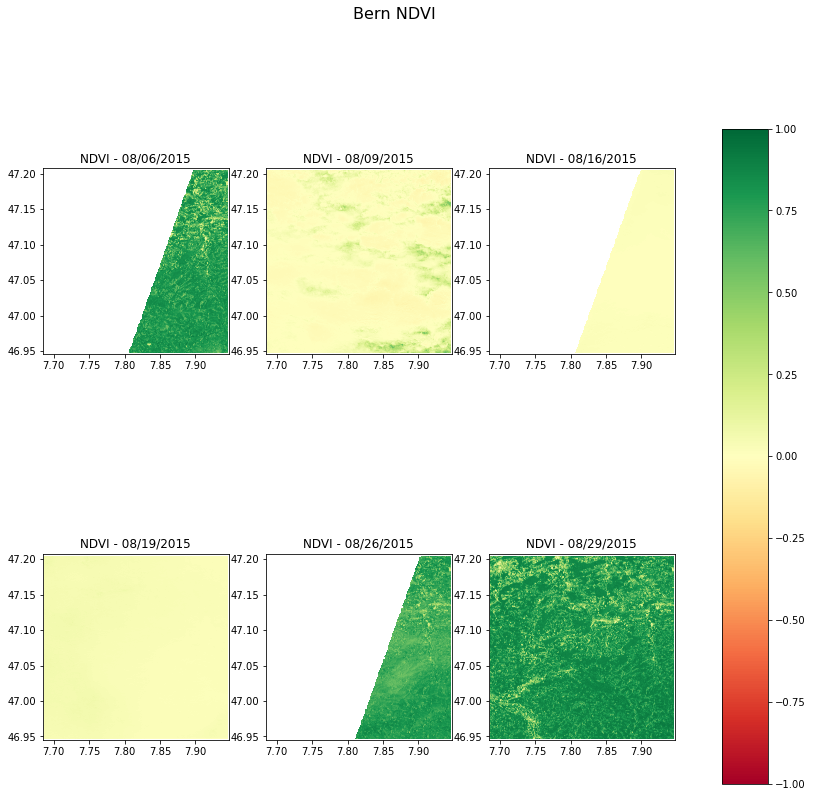

In [121]:
fig, axs = plt.subplots(2, 3, figsize=(13, 13))
im_09_02 = axs[0,0].imshow(query_bern_08_09.data[id_string_08_06], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_09_09 = axs[0,1].imshow(query_bern_08_09.data[id_string_08_09], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_09_12 = axs[0,2].imshow(query_bern_08_09.data[id_string_08_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_09_19 = axs[1,0].imshow(query_bern_08_09.data[id_string_08_19], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_09_22 = axs[1,1].imshow(query_bern_08_09.data[id_string_08_26], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_09_29 = axs[1,2].imshow(query_bern_08_09.data[id_string_08_29], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)

axs[0,0].set_title('NDVI - 08/06/2015')
axs[0,1].set_title('NDVI - 08/09/2015')
axs[0,2].set_title('NDVI - 08/16/2015')
axs[1,0].set_title('NDVI - 08/19/2015')
axs[1,1].set_title('NDVI - 08/26/2015')
axs[1,2].set_title('NDVI - 08/29/2015')
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im_09_12, cax=cbar_ax)
fig.suptitle('Bern NDVI', fontsize=16)
plt.savefig('bern_2015_0809.jpg')
plt.show()

## 09/2015 - 10/2015

In [122]:
dates = {
    '20150901' : datetime(2015, 9, 1, 12).strftime(iso8601),
    '20151001' : datetime(2015, 10, 1, 12).strftime(iso8601)
}

In [123]:
query_bern_09_10_json = {
    'layers' : [
        {
            
            'type' : 'raster', 'id' : rgbNirNdviLayers[lKey],
            # 'temporal' : {'intervals' : [{'snapshot' : dates[dKey]}]},
            'temporal' : {'intervals' : [{'start' : list(dates.values())[0], 'end': list(dates.values())[1]}]},
            # 'output' : False
        }
        for lKey in rgbNirNdviLayers
    ],
    "spatial" : {"type" : "square",  "coordinates" : ["46.94599", "7.68597", "47.20599", "7.94597"] }, #Some area in Bern
    "temporal" : {"intervals" : [{ #this is redundant whne the temporal key is defined in layers! But still needed
        "start" : datetime(2015, 9, 1, 12).strftime(iso8601), "end" : datetime(2015, 10, 1, 12).strftime(iso8601)
        
    }
    ]}
}

In [124]:
query_bern_09_10 = paw.PAIRSQuery(query_bern_09_10_json, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query_bern_09_10.submit()

INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Alright, using cache of PAIRS query with ID: '1663171200_15202746'


In [125]:
query_bern_09_10.poll_till_finished()
query_bern_09_10.download()
query_bern_09_10.create_layers()

INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663171200_15202746_f90516efe56dfbc5149eb76a57f7ab58.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.


In [129]:
response_format = "%m_%d_%YT%H_%M_%S"
layers_09_10_df = pd.DataFrame([k.split("-") for k in query_bern_09_10.metadata], columns=["dataset", "band", "date"])
layers_09_10_df["pixelMin"] = [query_bern_09_10.metadata[k]["details"]["rasterStatistics"]["pixelMin"] for k in query_bern_09_10.metadata]
layers_09_10_df["pixelMax"] = [query_bern_09_10.metadata[k]["details"]["rasterStatistics"]["pixelMax"] for k in query_bern_09_10.metadata]
layers_09_10_df["layerKey"] = query_bern_09_10.metadata.keys()
layers_09_10_df["date"] = pd.to_datetime(layers_09_10_df["date"], format=response_format)
layers_09_10_df = layers_09_10_df.sort_values(by='date')
layers_09_10_df

dataset  \
8   High res  imagery (ESA Sentinel 2)   
23  High res  imagery (ESA Sentinel 2)   
15  High res  imagery (ESA Sentinel 2)   
7   High res  imagery (ESA Sentinel 2)   
16  High res  imagery (ESA Sentinel 2)   
3   High res  imagery (ESA Sentinel 2)   
9   High res  imagery (ESA Sentinel 2)   
1   High res  imagery (ESA Sentinel 2)   
13  High res  imagery (ESA Sentinel 2)   
22  High res  imagery (ESA Sentinel 2)   
5   High res  imagery (ESA Sentinel 2)   
2   High res  imagery (ESA Sentinel 2)   
20  High res  imagery (ESA Sentinel 2)   
18  High res  imagery (ESA Sentinel 2)   
12  High res  imagery (ESA Sentinel 2)   
21  High res  imagery (ESA Sentinel 2)   
19  High res  imagery (ESA Sentinel 2)   
24  High res  imagery (ESA Sentinel 2)   
14  High res  imagery (ESA Sentinel 2)   
4   High res  imagery (ESA Sentinel 2)   
11  High res  imagery (ESA Sentinel 2)   
10  High res  imagery (ESA Sentinel 2)   
6   High res  imagery (ESA Sentinel 2)   
17  High res  imagery (ESA Sentinel 2)   
0   High res  imagery (ESA Sentinel 2)   

                                      band       date  pixelMin  pixelMax  \
8   Normalized difference vegetation index 2015-09-08    0.0000    0.9566   
23                            Band 4 (red) 2015-09-08    0.0003    1.6102   
15                           Band 2 (blue) 2015-09-08    0.0001    1.7417   
7                             Band 8 (NIR) 2015-09-08    0.0149    1.5389   
16                          Band 3 (green) 2015-09-08    0.0011    1.6670   
3   Normalized difference vegetation index 2015-09-15   -0.1253    0.2907   
9                             Band 4 (red) 2015-09-15    0.2537    1.1823   
1                             Band 8 (NIR) 2015-09-15    0.0321    1.1719   
13                           Band 2 (blue) 2015-09-15    0.2760    1.3350   
22                          Band 3 (green) 2015-09-15    0.0291    1.2242   
5                             Band 8 (NIR) 2015-09-18    0.4640    1.5487   
2                             Band 4 (red) 2015-09-18    0.4290    1.6210   
20  Normalized difference vegetation index 2015-09-18   -0.1119    0.0949   
18                          Band 3 (green) 2015-09-18    0.4627    1.6930   
12                           Band 2 (blue) 2015-09-18    0.4953    1.8074   
21  Normalized difference vegetation index 2015-09-25    0.0022    0.9782   
19                          Band 3 (green) 2015-09-25    0.0002    0.4597   
24                           Band 2 (blue) 2015-09-25    0.0001    0.1474   
14                            Band 8 (NIR) 2015-09-25    0.0029    0.7982   
4                             Band 4 (red) 2015-09-25    0.0001    0.4410   
11                           Band 2 (blue) 2015-09-28    0.0001    1.7538   
10                            Band 4 (red) 2015-09-28    0.0001    1.6075   
6                           Band 3 (green) 2015-09-28    0.0012    1.6634   
17  Normalized difference vegetation index 2015-09-28   -0.5661    0.9871   
0                             Band 8 (NIR) 2015-09-28    0.0141    1.5430   

                                             layerKey  
8   High res  imagery (ESA Sentinel 2)-Normalized ...  
23  High res  imagery (ESA Sentinel 2)-Band 4 (red...  
15  High res  imagery (ESA Sentinel 2)-Band 2 (blu...  
7   High res  imagery (ESA Sentinel 2)-Band 8 (NIR...  
16  High res  imagery (ESA Sentinel 2)-Band 3 (gre...  
3   High res  imagery (ESA Sentinel 2)-Normalized ...  
9   High res  imagery (ESA Sentinel 2)-Band 4 (red...  
1   High res  imagery (ESA Sentinel 2)-Band 8 (NIR...  
13  High res  imagery (ESA Sentinel 2)-Band 2 (blu...  
22  High res  imagery (ESA Sentinel 2)-Band 3 (gre...  
5   High res  imagery (ESA Sentinel 2)-Band 8 (NIR...  
2   High res  imagery (ESA Sentinel 2)-Band 4 (red...  
20  High res  imagery (ESA Sentinel 2)-Normalized ...  
18  High res  imagery (ESA Sentinel 2)-Band 3 (gre...  
12  High res  imagery (ESA Sentinel 2)-Band 2 (blu...  
21  High res  imagery (ESA Sentinel 2)-

In [130]:
query_metadata_09_10 = pd.DataFrame(query_bern_09_10.metadata).transpose()
extent = [7.684864, 7.947008, 46.945664, 47.207808]

In [132]:
id_string_09_08 = create_id_string(query_metadata_09_10,'49464','09-08-2015T00:00:00Z')
id_string_09_15 = create_id_string(query_metadata_09_10,'49464','09-15-2015T00:00:00Z')
id_string_09_18 = create_id_string(query_metadata_09_10,'49464','09-18-2015T00:00:00Z')
id_string_09_25 = create_id_string(query_metadata_09_10,'49464','09-25-2015T00:00:00Z')
id_string_09_28 = create_id_string(query_metadata_09_10,'49464','09-28-2015T00:00:00Z')

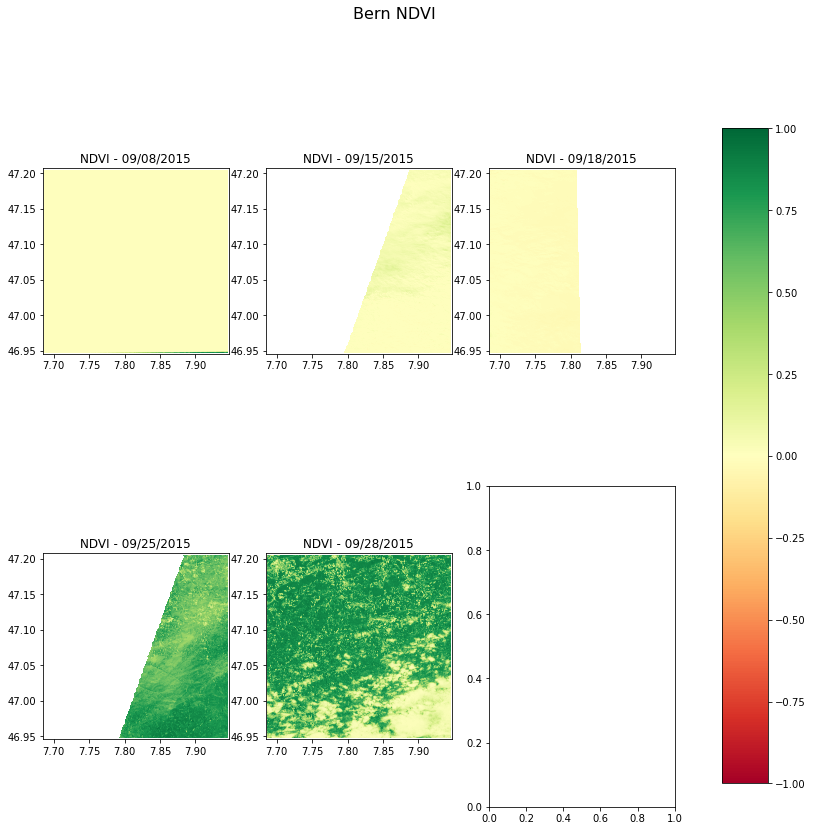

In [133]:
fig, axs = plt.subplots(2, 3, figsize=(13, 13))
im_09_08 = axs[0,0].imshow(query_bern_09_10.data[id_string_09_08], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_09_15 = axs[0,1].imshow(query_bern_09_10.data[id_string_09_15], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_09_18 = axs[0,2].imshow(query_bern_09_10.data[id_string_09_18], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_09_25 = axs[1,0].imshow(query_bern_09_10.data[id_string_09_25], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_09_28 = axs[1,1].imshow(query_bern_09_10.data[id_string_09_28], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)

axs[0,0].set_title('NDVI - 09/08/2015')
axs[0,1].set_title('NDVI - 09/15/2015')
axs[0,2].set_title('NDVI - 09/18/2015')
axs[1,0].set_title('NDVI - 09/25/2015')
axs[1,1].set_title('NDVI - 09/28/2015')
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im_09_08, cax=cbar_ax)
fig.suptitle('Bern NDVI', fontsize=16)
plt.savefig('bern_2015_0910.jpg')
plt.show()

# 10/2015-11/2015
## No Data!!

In [29]:
dates = {
    '20151001' : datetime(2015, 10, 1, 12).strftime(iso8601),
    '20151101' : datetime(2015, 11, 1, 12).strftime(iso8601)
}

In [30]:
query_bern_10_11_15_json = {
    'layers' : [
        {
            
            'type' : 'raster', 'id' : rgbNirNdviLayers[lKey],
            # 'temporal' : {'intervals' : [{'snapshot' : dates[dKey]}]},
            'temporal' : {'intervals' : [{'start' : list(dates.values())[0], 'end': list(dates.values())[1]}]},
            # 'output' : False
        }
        for lKey in rgbNirNdviLayers
    ],
    "spatial" : {"type" : "square",  "coordinates" : ["46.94599", "7.68597", "47.20599", "7.94597"] }, #Some area in Bern
    "temporal" : {"intervals" : [{ #this is redundant whne the temporal key is defined in layers! But still needed
        "start" : datetime(2015, 10, 1, 12).strftime(iso8601), "end" : datetime(2015, 11, 1, 12).strftime(iso8601)
        
    }
    ]}
}

In [34]:
query_bern_10_11_15 = paw.PAIRSQuery(query_bern_10_11_15_json, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query_bern_10_11_15.submit()

INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663214400_16889467


In [35]:
query_bern_10_11_15.poll_till_finished()
query_bern_10_11_15.download()
query_bern_10_11_15.create_layers()

INFO:ibmpairs.paw:Bummer, the PAIRS query finished, but you'll never be able to download anything, status code: '21' (NoDataFound)


Exception: Bummer, the PAIRS query finished, but you'll never be able to download anything, status code: '21' (NoDataFound)

## 11/2015 - 12/2015

In [36]:
dates = {
    '20151101' : datetime(2015, 11, 1, 12).strftime(iso8601),
    '20151201' : datetime(2015, 12, 1, 12).strftime(iso8601)
}

In [37]:
query_bern_11_12_15_json = {
    'layers' : [
        {
            
            'type' : 'raster', 'id' : rgbNirNdviLayers[lKey],
            # 'temporal' : {'intervals' : [{'snapshot' : dates[dKey]}]},
            'temporal' : {'intervals' : [{'start' : list(dates.values())[0], 'end': list(dates.values())[1]}]},
            # 'output' : False
        }
        for lKey in rgbNirNdviLayers
    ],
    "spatial" : {"type" : "square",  "coordinates" : ["46.94599", "7.68597", "47.20599", "7.94597"] }, #Some area in Bern
    "temporal" : {"intervals" : [{ #this is redundant whne the temporal key is defined in layers! But still needed
        "start" : datetime(2015, 11, 1, 12).strftime(iso8601), "end" : datetime(2015, 12, 1, 12).strftime(iso8601)
        
    }
    ]}
}

In [38]:
query_bern_11_12_15 = paw.PAIRSQuery(query_bern_11_12_15_json, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query_bern_11_12_15.submit()

INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663214400_17118466


In [39]:
query_bern_11_12_15.poll_till_finished()
query_bern_11_12_15.download()
query_bern_11_12_15.create_layers()

INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663214400_17118466_50bead9c91b1fdba669de10fe444d253.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.


In [41]:
response_format = "%m_%d_%YT%H_%M_%S"
layers_11_12_15_df = pd.DataFrame([k.split("-") for k in query_bern_11_12_15.metadata], columns=["dataset", "band", "date"])
layers_11_12_15_df["pixelMin"] = [query_bern_11_12_15.metadata[k]["details"]["rasterStatistics"]["pixelMin"] for k in query_bern_11_12_15.metadata]
layers_11_12_15_df["pixelMax"] = [query_bern_11_12_15.metadata[k]["details"]["rasterStatistics"]["pixelMax"] for k in query_bern_11_12_15.metadata]
layers_11_12_15_df["layerKey"] = query_bern_11_12_15.metadata.keys()
layers_11_12_15_df["date"] = pd.to_datetime(layers_11_12_15_df["date"], format=response_format)
layers_11_12_15_df = layers_11_12_15_df.sort_values(by='date')
layers_11_12_15_df

dataset  \
14  High res  imagery (ESA Sentinel 2)   
2   High res  imagery (ESA Sentinel 2)   
13  High res  imagery (ESA Sentinel 2)   
12  High res  imagery (ESA Sentinel 2)   
10  High res  imagery (ESA Sentinel 2)   
0   High res  imagery (ESA Sentinel 2)   
11  High res  imagery (ESA Sentinel 2)   
8   High res  imagery (ESA Sentinel 2)   
19  High res  imagery (ESA Sentinel 2)   
1   High res  imagery (ESA Sentinel 2)   
6   High res  imagery (ESA Sentinel 2)   
4   High res  imagery (ESA Sentinel 2)   
16  High res  imagery (ESA Sentinel 2)   
17  High res  imagery (ESA Sentinel 2)   
7   High res  imagery (ESA Sentinel 2)   
18  High res  imagery (ESA Sentinel 2)   
5   High res  imagery (ESA Sentinel 2)   
3   High res  imagery (ESA Sentinel 2)   
15  High res  imagery (ESA Sentinel 2)   
9   High res  imagery (ESA Sentinel 2)   

                                      band       date  pixelMin  pixelMax  \
14  Normalized difference vegetation index 2015-11-14   -0.0753    0.7639   
2                             Band 8 (NIR) 2015-11-14    0.0913    1.3576   
13                          Band 3 (green) 2015-11-14    0.0450    1.3637   
12                            Band 4 (red) 2015-11-14    0.0462    1.3119   
10                           Band 2 (blue) 2015-11-14    0.0309    1.4212   
0                             Band 4 (red) 2015-11-17    0.0057    1.4652   
11                           Band 2 (blue) 2015-11-17    0.0001    1.6350   
8   Normalized difference vegetation index 2015-11-17   -0.3256    0.8609   
19                            Band 8 (NIR) 2015-11-17    0.0402    1.4334   
1                           Band 3 (green) 2015-11-17    0.0024    1.5532   
6                             Band 8 (NIR) 2015-11-24    0.0002    1.5608   
4                             Band 4 (red) 2015-11-24    0.0001    1.6110   
16                          Band 3 (green) 2015-11-24    0.0001    1.6681   
17  Normalized difference vegetation index 2015-11-24   -0.4944    0.9890   
7                            Band 2 (blue) 2015-11-24    0.0001    1.7510   
18                           Band 2 (blue) 2015-11-27    0.0007    1.6836   
5   Normalized difference vegetation index 2015-11-27   -0.2812    0.9277   
3                             Band 4 (red) 2015-11-27    0.0036    1.5918   
15                          Band 3 (green) 2015-11-27    0.0056    1.6290   
9                             Band 8 (NIR) 2015-11-27    0.0225    1.5545   

                                             layerKey  
14  High res  imagery (ESA Sentinel 2)-Normalized ...  
2   High res  imagery (ESA Sentinel 2)-Band 8 (NIR...  
13  High res  imagery (ESA Sentinel 2)-Band 3 (gre...  
12  High res  imagery (ESA Sentinel 2)-Band 4 (red...  
10  High res  imagery (ESA Sentinel 2)-Band 2 (blu...  
0   High res  imagery (ESA Sentinel 2)-Band 4 (red...  
11  High res  imagery (ESA Sentinel 2)-Band 2 (blu...  
8   High res  imagery (ESA Sentinel 2)-Normalized ...  
19  High res  imagery (ESA Sentinel 2)-Band 8 (NIR...  
1   High res  imagery (ESA Sentinel 2)-Band 3 (gre...  
6   High res  imagery (ESA Sentinel 2)-Band 8 (NIR...  
4   High res  imagery (ESA Sentinel 2)-Band 4 (red...  
16  High res  imagery (ESA Sentinel 2)-Band 3 (gre...  
17  High res  imagery (ESA Sentinel 2)-Normalized ...  
7   High res  imagery (ESA Sentinel 2)-Band 2 (blu...  
18  High res  imagery (ESA Sentinel 2)-Band 2 (blu...  
5   High res  imagery (ESA Sentinel 2)-Normalized ...  
3   High res  imagery (ESA Sentinel 2)-Band 4 (red...  
15  High res  imagery (ESA Sentinel 2)-Band 3 (gre...  
9   High res  imagery (ESA Sentinel 2)-Band 8 (NIR...

In [42]:
query_metadata_11_12_15 = pd.DataFrame(query_bern_11_12_15.metadata).transpose()
extent = [7.684864, 7.947008, 46.945664, 47.207808]

In [44]:
id_string_11_14 = create_id_string(query_metadata_11_12_15,'49464','11-14-2015T00:00:00Z')
id_string_11_17 = create_id_string(query_metadata_11_12_15,'49464','11-17-2015T00:00:00Z')
id_string_11_24 = create_id_string(query_metadata_11_12_15,'49464','11-24-2015T00:00:00Z')
id_string_11_27 = create_id_string(query_metadata_11_12_15,'49464','11-27-2015T00:00:00Z')

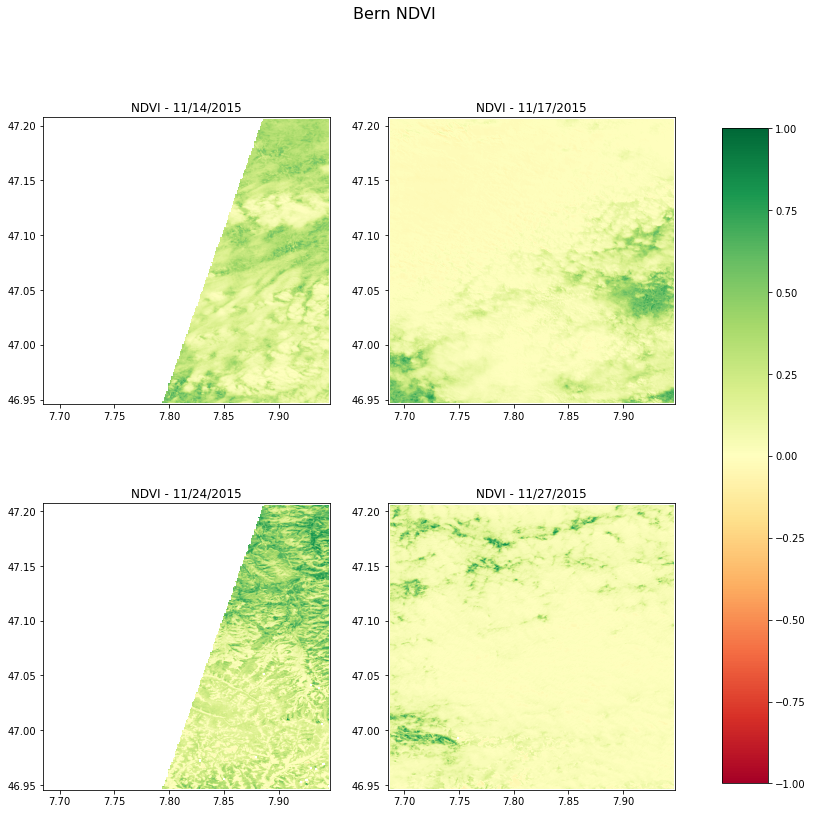

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13))
im_11_14 = axs[0,0].imshow(query_bern_11_12_15.data[id_string_11_14], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_11_17 = axs[0,1].imshow(query_bern_11_12_15.data[id_string_11_17], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_11_24 = axs[1,0].imshow(query_bern_11_12_15.data[id_string_11_24], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_11_27 = axs[1,1].imshow(query_bern_11_12_15.data[id_string_11_27], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)

axs[0,0].set_title('NDVI - 11/14/2015')
axs[0,1].set_title('NDVI - 11/17/2015')
axs[1,0].set_title('NDVI - 11/24/2015')
axs[1,1].set_title('NDVI - 11/27/2015')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im_11_24, cax=cbar_ax)
fig.suptitle('Bern NDVI', fontsize=16)
plt.savefig('bern_2015_1112.jpg')
plt.show()

## 2016

## Some Area in Bern, 08/2016-09/2016

In [7]:
dates = {
    '20160801' : datetime(2016, 8, 1, 12).strftime(iso8601),
    '20160901' : datetime(2016, 9, 1, 12).strftime(iso8601)
}

In [10]:
query_bern_08_09_16_json = {
    'layers' : [
        {
            
            'type' : 'raster', 'id' : rgbNirNdviLayers[lKey],
            # 'temporal' : {'intervals' : [{'snapshot' : dates[dKey]}]},
            'temporal' : {'intervals' : [{'start' : list(dates.values())[0], 'end': list(dates.values())[1]}]},
            # 'output' : False
        }
        for lKey in rgbNirNdviLayers
    ],
    "spatial" : {"type" : "square",  "coordinates" : ["46.94599", "7.68597", "47.20599", "7.94597"] }, #Some area in Bern
    "temporal" : {"intervals" : [{ #this is redundant whne the temporal key is defined in layers! But still needed
        "start" : datetime(2016, 8, 1, 12).strftime(iso8601), "end" : datetime(2016, 9, 1, 12).strftime(iso8601)
        
    }
    ]}
}

In [11]:
query_bern_08_09_16 = paw.PAIRSQuery(query_bern_08_09_16_json, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query_bern_08_09_16.submit()

INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663214400_11935114


In [13]:
query_bern_08_09_16.poll_till_finished()
query_bern_08_09_16.download()
query_bern_08_09_16.create_layers()

INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663214400_11935114_9fda0d9fcdbb70f9916f8ae746e1ef48.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.


In [14]:
response_format = "%m_%d_%YT%H_%M_%S"
layers_08_09_16_df = pd.DataFrame([k.split("-") for k in query_bern_08_09_16.metadata], columns=["dataset", "band", "date"])
layers_08_09_16_df["pixelMin"] = [query_bern_08_09_16.metadata[k]["details"]["rasterStatistics"]["pixelMin"] for k in query_bern_08_09_16.metadata]
layers_08_09_16_df["pixelMax"] = [query_bern_08_09_16.metadata[k]["details"]["rasterStatistics"]["pixelMax"] for k in query_bern_08_09_16.metadata]
layers_08_09_16_df["layerKey"] = query_bern_08_09_16.metadata.keys()
layers_08_09_16_df["date"] = pd.to_datetime(layers_08_09_16_df["date"], format=response_format)
layers_08_09_16_df = layers_08_09_16_df.sort_values(by='date')
layers_08_09_16_df

dataset  \
27  High res  imagery (ESA Sentinel 2)   
26  High res  imagery (ESA Sentinel 2)   
20  High res  imagery (ESA Sentinel 2)   
18  High res  imagery (ESA Sentinel 2)   
10  High res  imagery (ESA Sentinel 2)   
29  High res  imagery (ESA Sentinel 2)   
23  High res  imagery (ESA Sentinel 2)   
15  High res  imagery (ESA Sentinel 2)   
28  High res  imagery (ESA Sentinel 2)   
12  High res  imagery (ESA Sentinel 2)   
22  High res  imagery (ESA Sentinel 2)   
21  High res  imagery (ESA Sentinel 2)   
0   High res  imagery (ESA Sentinel 2)   
5   High res  imagery (ESA Sentinel 2)   
8   High res  imagery (ESA Sentinel 2)   
9   High res  imagery (ESA Sentinel 2)   
2   High res  imagery (ESA Sentinel 2)   
24  High res  imagery (ESA Sentinel 2)   
3   High res  imagery (ESA Sentinel 2)   
11  High res  imagery (ESA Sentinel 2)   
1   High res  imagery (ESA Sentinel 2)   
4   High res  imagery (ESA Sentinel 2)   
13  High res  imagery (ESA Sentinel 2)   
6   High res  imagery (ESA Sentinel 2)   
14  High res  imagery (ESA Sentinel 2)   
19  High res  imagery (ESA Sentinel 2)   
7   High res  imagery (ESA Sentinel 2)   
25  High res  imagery (ESA Sentinel 2)   
17  High res  imagery (ESA Sentinel 2)   
16  High res  imagery (ESA Sentinel 2)   

                                      band       date  pixelMin  pixelMax  \
27                            Band 4 (red) 2016-08-03    0.0036    1.6030   
26                           Band 2 (blue) 2016-08-03    0.0002    1.7447   
20  Normalized difference vegetation index 2016-08-03   -0.0413    0.9346   
18                          Band 3 (green) 2016-08-03    0.0050    1.6562   
10                            Band 8 (NIR) 2016-08-03    0.0461    1.5373   
29                            Band 4 (red) 2016-08-10    0.0203    1.6350   
23  Normalized difference vegetation index 2016-08-10   -0.2145    0.8547   
15                           Band 2 (blue) 2016-08-10    0.0265    1.7891   
28                          Band 3 (green) 2016-08-10    0.0341    1.6959   
12                            Band 8 (NIR) 2016-08-10    0.0973    1.5593   
22  Normalized difference vegetation index 2016-08-13   -0.3326    0.9973   
21                            Band 4 (red) 2016-08-13    0.0001    1.5989   
0                           Band 3 (green) 2016-08-13    0.0001    1.6544   
5                            Band 2 (blue) 2016-08-13    0.0001    1.7462   
8                             Band 8 (NIR) 2016-08-13    0.0158    1.5367   
9                            Band 2 (blue) 2016-08-20    0.7423    1.0330   
2                           Band 3 (green) 2016-08-20    0.7664    1.0153   
24  Normalized difference vegetation index 2016-08-20    0.0026    0.0421   
3                             Band 4 (red) 2016-08-20    0.7759    0.9897   
11                            Band 8 (NIR) 2016-08-20    0.8313    1.0075   
1   Normalized difference vegetation index 2016-08-23   -0.4527    0.9982   
4                            Band 2 (blue) 2016-08-23    0.0001    1.7543   
13                            Band 4 (red) 2016-08-23    0.0001    1.6044   
6                             Band 8 (NIR) 2016-08-23    0.0065    1.5422   
14                          Band 3 (green) 2016-08-23    0.0001    1.6598   
19                           Band 2 (blue) 2016-08-30    0.0280    1.6879   
7                             Band 8 (NIR) 2016-08-30    0.0718    1.5535   
25                          Band 3 (green) 2016-08-30    0.0279    1.6289   
17                            Band 4 (red) 2016-08-30    0.0165    1.6034   
16  Normalized difference vegetation index 2016-08-30   -0.0984    0.8957   

                                             layerKey  
27  High res  imagery (ESA Sentinel 2)-Band 4 (red...  
26  High res  imagery (ESA Sentinel 2)-Band 2 (blu...  
20  High res  imagery (ESA Sentinel 2)-Normalized ...  
18  High res  imagery (ESA Sentinel 2)-Band 3 (gre...  
10  High res  imagery (ESA Sentinel 2)-Band 8 (NIR...  
29  

In [15]:
query_metadata_08_09_16 = pd.DataFrame(query_bern_08_09_16.metadata).transpose()
extent = [7.684864, 7.947008, 46.945664, 47.207808]

In [18]:
id_string_08_03_16 = create_id_string(query_metadata_08_09_16,'49464','08-03-2016T00:00:00Z')
id_string_08_10_16 = create_id_string(query_metadata_08_09_16,'49464','08-10-2016T00:00:00Z')
id_string_08_13_16 = create_id_string(query_metadata_08_09_16,'49464','08-13-2016T00:00:00Z')
id_string_08_20_16 = create_id_string(query_metadata_08_09_16,'49464','08-20-2016T00:00:00Z')
id_string_08_23_16 = create_id_string(query_metadata_08_09_16,'49464','08-23-2016T00:00:00Z')

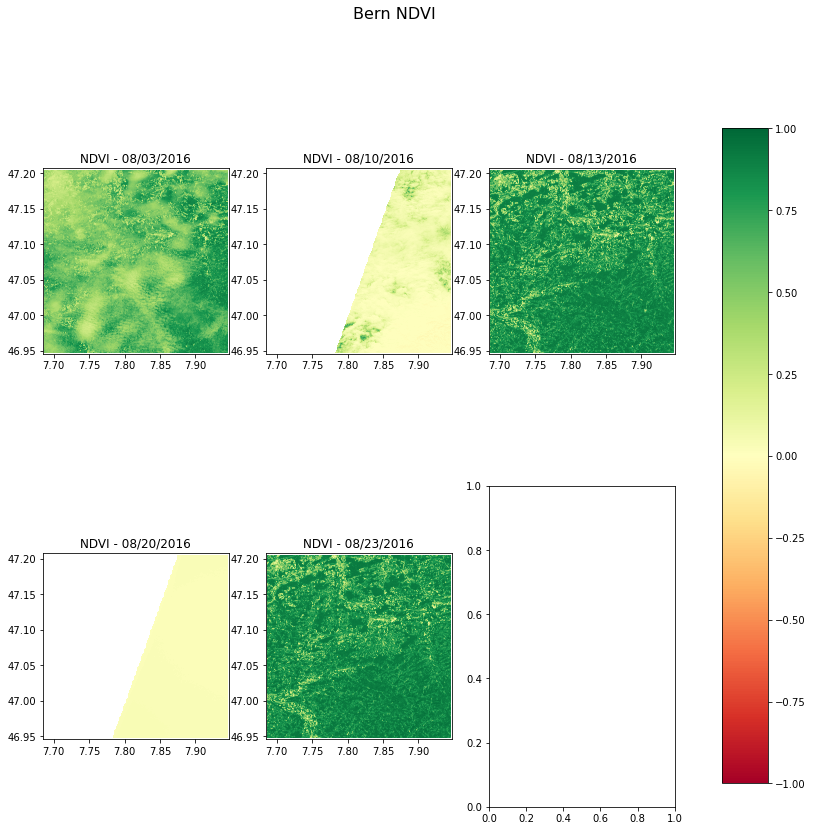

In [110]:
fig, axs = plt.subplots(2, 3, figsize=(13, 13))
im_08_03_16 = axs[0,0].imshow(query_bern_08_09_16.data[id_string_08_03_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_08_10_16 = axs[0,1].imshow(query_bern_08_09_16.data[id_string_08_10_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_08_13_16 = axs[0,2].imshow(query_bern_08_09_16.data[id_string_08_13_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_08_20_16 = axs[1,0].imshow(query_bern_08_09_16.data[id_string_08_20_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_08_23_16 = axs[1,1].imshow(query_bern_08_09_16.data[id_string_08_23_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)

axs[0,0].set_title('NDVI - 08/03/2016')
axs[0,1].set_title('NDVI - 08/10/2016')
axs[0,2].set_title('NDVI - 08/13/2016')
axs[1,0].set_title('NDVI - 08/20/2016')
axs[1,1].set_title('NDVI - 08/23/2016')
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im_08_23_16, cax=cbar_ax)
fig.suptitle('Bern NDVI', fontsize=16)
plt.savefig('bern_2016_0809.jpg')
plt.show()

## Some Area in Bern, 09/2016-10/2016

In [20]:
dates = {
    '20160901' : datetime(2016, 9, 1, 12).strftime(iso8601),
    '20161001' : datetime(2016, 10, 1, 12).strftime(iso8601)
}

In [21]:
query_bern_09_10_16_json = {
    'layers' : [
        {
            
            'type' : 'raster', 'id' : rgbNirNdviLayers[lKey],
            # 'temporal' : {'intervals' : [{'snapshot' : dates[dKey]}]},
            'temporal' : {'intervals' : [{'start' : list(dates.values())[0], 'end': list(dates.values())[1]}]},
            # 'output' : False
        }
        for lKey in rgbNirNdviLayers
    ],
    "spatial" : {"type" : "square",  "coordinates" : ["46.94599", "7.68597", "47.20599", "7.94597"] }, #Some area in Bern
    "temporal" : {"intervals" : [{ #this is redundant whne the temporal key is defined in layers! But still needed
        "start" : datetime(2016, 9, 1, 12).strftime(iso8601), "end" : datetime(2016, 10, 1, 12).strftime(iso8601)
        
    }
    ]}
}

In [22]:
query_bern_09_10_16 = paw.PAIRSQuery(query_bern_09_10_16_json, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query_bern_09_10_16.submit()

INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663214400_14260048


In [23]:
query_bern_09_10_16.poll_till_finished()
query_bern_09_10_16.download()
query_bern_09_10_16.create_layers()

INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663214400_14260048_147fa871914779051f9432f8b22fcd3e.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.


In [24]:
response_format = "%m_%d_%YT%H_%M_%S"
layers_09_10_16_df = pd.DataFrame([k.split("-") for k in query_bern_09_10_16.metadata], columns=["dataset", "band", "date"])
layers_09_10_16_df["pixelMin"] = [query_bern_09_10_16.metadata[k]["details"]["rasterStatistics"]["pixelMin"] for k in query_bern_09_10_16.metadata]
layers_09_10_16_df["pixelMax"] = [query_bern_09_10_16.metadata[k]["details"]["rasterStatistics"]["pixelMax"] for k in query_bern_09_10_16.metadata]
layers_09_10_16_df["layerKey"] = query_bern_09_10_16.metadata.keys()
layers_09_10_16_df["date"] = pd.to_datetime(layers_09_10_16_df["date"], format=response_format)
layers_09_10_16_df = layers_09_10_16_df.sort_values(by='date')
layers_09_10_16_df

dataset  \
24  High res  imagery (ESA Sentinel 2)   
22  High res  imagery (ESA Sentinel 2)   
20  High res  imagery (ESA Sentinel 2)   
19  High res  imagery (ESA Sentinel 2)   
16  High res  imagery (ESA Sentinel 2)   
14  High res  imagery (ESA Sentinel 2)   
6   High res  imagery (ESA Sentinel 2)   
17  High res  imagery (ESA Sentinel 2)   
10  High res  imagery (ESA Sentinel 2)   
28  High res  imagery (ESA Sentinel 2)   
27  High res  imagery (ESA Sentinel 2)   
23  High res  imagery (ESA Sentinel 2)   
0   High res  imagery (ESA Sentinel 2)   
11  High res  imagery (ESA Sentinel 2)   
5   High res  imagery (ESA Sentinel 2)   
13  High res  imagery (ESA Sentinel 2)   
15  High res  imagery (ESA Sentinel 2)   
26  High res  imagery (ESA Sentinel 2)   
3   High res  imagery (ESA Sentinel 2)   
2   High res  imagery (ESA Sentinel 2)   
1   High res  imagery (ESA Sentinel 2)   
25  High res  imagery (ESA Sentinel 2)   
7   High res  imagery (ESA Sentinel 2)   
12  High res  imagery (ESA Sentinel 2)   
4   High res  imagery (ESA Sentinel 2)   
21  High res  imagery (ESA Sentinel 2)   
8   High res  imagery (ESA Sentinel 2)   
9   High res  imagery (ESA Sentinel 2)   
18  High res  imagery (ESA Sentinel 2)   
29  High res  imagery (ESA Sentinel 2)   

                                      band       date  pixelMin  pixelMax  \
24  Normalized difference vegetation index 2016-09-02   -0.5347    0.9738   
22                            Band 4 (red) 2016-09-02    0.0038    1.6336   
20                          Band 3 (green) 2016-09-02    0.0037    1.6965   
19                           Band 2 (blue) 2016-09-02    0.0001    1.7998   
16                            Band 8 (NIR) 2016-09-02    0.0232    1.5603   
14                          Band 3 (green) 2016-09-09    0.0001    1.6842   
6                             Band 4 (red) 2016-09-09    0.0001    1.6212   
17                            Band 8 (NIR) 2016-09-09    0.0124    1.5454   
10  Normalized difference vegetation index 2016-09-09   -0.3011    0.9981   
28                           Band 2 (blue) 2016-09-09    0.0001    1.7903   
27  Normalized difference vegetation index 2016-09-12   -0.2883    0.9427   
23                           Band 2 (blue) 2016-09-12    0.0001    1.6403   
0                             Band 4 (red) 2016-09-12    0.0017    1.4648   
11                            Band 8 (NIR) 2016-09-12    0.0145    1.5406   
5                           Band 3 (green) 2016-09-12    0.0029    1.3926   
13                            Band 4 (red) 2016-09-19    0.2791    1.6432   
15                            Band 8 (NIR) 2016-09-19    0.2440    1.5760   
26  Normalized difference vegetation index 2016-09-19   -0.2855    0.1397   
3                            Band 2 (blue) 2016-09-19    0.3732    1.7751   
2                           Band 3 (green) 2016-09-19    0.3196    1.7016   
1                             Band 8 (NIR) 2016-09-22    0.0146    1.4738   
25                            Band 4 (red) 2016-09-22    0.0001    1.5800   
7                            Band 2 (blue) 2016-09-22    0.0001    1.2752   
12  Normalized difference vegetation index 2016-09-22   -0.6753    0.9962   
4                           Band 3 (green) 2016-09-22    0.0001    1.3772   
21                            Band 8 (NIR) 2016-09-29    0.0035    1.3848   
8   Normalized difference vegetation index 2016-09-29   -0.2751    0.9984   
9                            Band 2 (blue) 2016-09-29    0.0001    1.2949   
18                          Band 3 (green) 2016-09-29    0.0001    1.2754   
29                            Band 4 (red) 2016-09-29    0.0001    1.6062   

                                             layerKey  
24  High res  imagery (ESA Sentinel 2)-Normalized ...  
22  High res  imagery (ESA Sentinel 2)-Band 4 (red...  
20  High res  imagery (ESA Sentinel 2)-Band 3 (gre...  
19  High res  imagery (ESA Sentinel 2)-Band 2 (blu...  
16  High res  imagery (ESA Sentinel 2)-Band 8 (NIR...  
14  

In [25]:
query_metadata_09_10_16 = pd.DataFrame(query_bern_09_10_16.metadata).transpose()
extent = [7.684864, 7.947008, 46.945664, 47.207808]

In [27]:
id_string_09_02_16 = create_id_string(query_metadata_09_10_16,'49464','09-02-2016T00:00:00Z')
id_string_09_09_16 = create_id_string(query_metadata_09_10_16,'49464','09-09-2016T00:00:00Z')
id_string_09_12_16 = create_id_string(query_metadata_09_10_16,'49464','09-12-2016T00:00:00Z')
id_string_09_19_16 = create_id_string(query_metadata_09_10_16,'49464','09-19-2016T00:00:00Z')
id_string_09_22_16 = create_id_string(query_metadata_09_10_16,'49464','09-22-2016T00:00:00Z')
id_string_09_29_16 = create_id_string(query_metadata_09_10_16,'49464','09-29-2016T00:00:00Z')

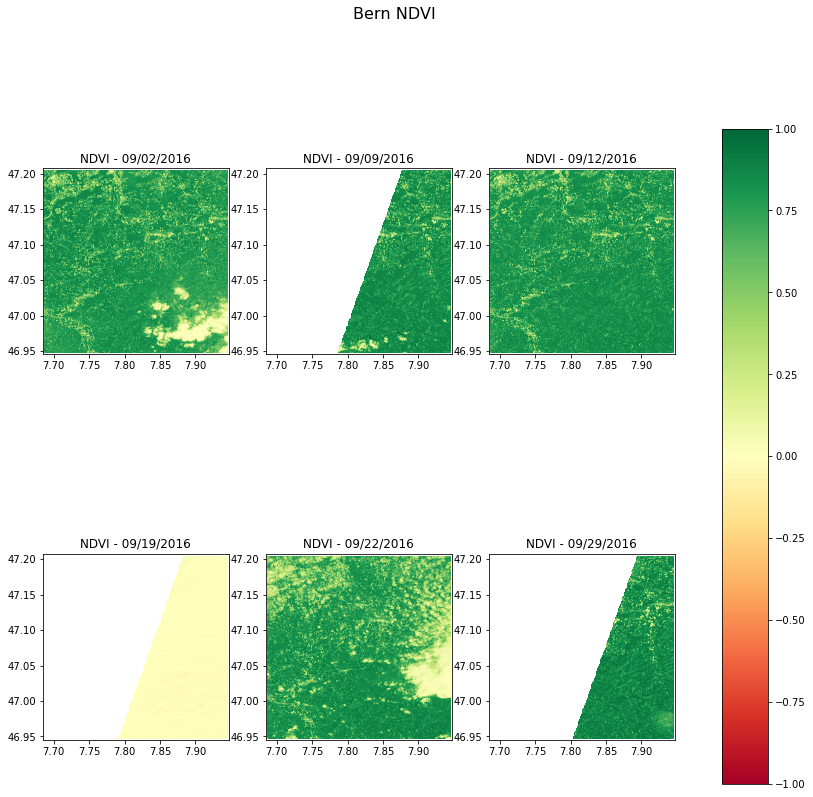

In [109]:
fig, axs = plt.subplots(2, 3, figsize=(13, 13))
im_09_02_16 = axs[0,0].imshow(query_bern_09_10_16.data[id_string_09_02_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_09_09_16 = axs[0,1].imshow(query_bern_09_10_16.data[id_string_09_09_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_09_12_16 = axs[0,2].imshow(query_bern_09_10_16.data[id_string_09_12_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_09_19_16 = axs[1,0].imshow(query_bern_09_10_16.data[id_string_09_19_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_09_22_16 = axs[1,1].imshow(query_bern_09_10_16.data[id_string_09_22_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_09_29_16 = axs[1,2].imshow(query_bern_09_10_16.data[id_string_09_29_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)

axs[0,0].set_title('NDVI - 09/02/2016')
axs[0,1].set_title('NDVI - 09/09/2016')
axs[0,2].set_title('NDVI - 09/12/2016')
axs[1,0].set_title('NDVI - 09/19/2016')
axs[1,1].set_title('NDVI - 09/22/2016')
axs[1,2].set_title('NDVI - 09/29/2016')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im_08_23_16, cax=cbar_ax)
fig.suptitle('Bern NDVI', fontsize=16)
plt.savefig('bern_2016_0910.jpg')
plt.show()

## 10/2016 - 11/2016

In [48]:
dates = {
    '20161001' : datetime(2016, 10, 1, 12).strftime(iso8601),
    '20161101' : datetime(2016, 11, 1, 12).strftime(iso8601)
}

In [49]:
query_bern_10_11_16_json = {
    'layers' : [
        {
            
            'type' : 'raster', 'id' : rgbNirNdviLayers[lKey],
            # 'temporal' : {'intervals' : [{'snapshot' : dates[dKey]}]},
            'temporal' : {'intervals' : [{'start' : list(dates.values())[0], 'end': list(dates.values())[1]}]},
            # 'output' : False
        }
        for lKey in rgbNirNdviLayers
    ],
    "spatial" : {"type" : "square",  "coordinates" : ["46.94599", "7.68597", "47.20599", "7.94597"] }, #Some area in Bern
    "temporal" : {"intervals" : [{ #this is redundant whne the temporal key is defined in layers! But still needed
        "start" : datetime(2016, 10, 1, 12).strftime(iso8601), "end" : datetime(2016, 11, 1, 12).strftime(iso8601)
        
    }
    ]}
}

In [50]:
query_bern_10_11_16 = paw.PAIRSQuery(query_bern_10_11_16_json, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query_bern_10_11_16.submit()

INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663214400_17950425


In [51]:
query_bern_10_11_16.poll_till_finished()
query_bern_10_11_16.download()
query_bern_10_11_16.create_layers()

INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663214400_17950425_778c1950e2a2e29cba720dba25a888ef.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.


In [52]:
response_format = "%m_%d_%YT%H_%M_%S"
layers_10_11_16_df = pd.DataFrame([k.split("-") for k in query_bern_10_11_16.metadata], columns=["dataset", "band", "date"])
layers_10_11_16_df["pixelMin"] = [query_bern_10_11_16.metadata[k]["details"]["rasterStatistics"]["pixelMin"] for k in query_bern_10_11_16.metadata]
layers_10_11_16_df["pixelMax"] = [query_bern_10_11_16.metadata[k]["details"]["rasterStatistics"]["pixelMax"] for k in query_bern_10_11_16.metadata]
layers_10_11_16_df["layerKey"] = query_bern_10_11_16.metadata.keys()
layers_10_11_16_df["date"] = pd.to_datetime(layers_10_11_16_df["date"], format=response_format)
layers_10_11_16_df = layers_10_11_16_df.sort_values(by='date')
layers_10_11_16_df

dataset  \
34  High res  imagery (ESA Sentinel 2)   
1   High res  imagery (ESA Sentinel 2)   
29  High res  imagery (ESA Sentinel 2)   
16  High res  imagery (ESA Sentinel 2)   
7   High res  imagery (ESA Sentinel 2)   
24  High res  imagery (ESA Sentinel 2)   
23  High res  imagery (ESA Sentinel 2)   
13  High res  imagery (ESA Sentinel 2)   
0   High res  imagery (ESA Sentinel 2)   
2   High res  imagery (ESA Sentinel 2)   
30  High res  imagery (ESA Sentinel 2)   
6   High res  imagery (ESA Sentinel 2)   
14  High res  imagery (ESA Sentinel 2)   
5   High res  imagery (ESA Sentinel 2)   
22  High res  imagery (ESA Sentinel 2)   
21  High res  imagery (ESA Sentinel 2)   
10  High res  imagery (ESA Sentinel 2)   
28  High res  imagery (ESA Sentinel 2)   
18  High res  imagery (ESA Sentinel 2)   
26  High res  imagery (ESA Sentinel 2)   
32  High res  imagery (ESA Sentinel 2)   
3   High res  imagery (ESA Sentinel 2)   
4   High res  imagery (ESA Sentinel 2)   
9   High res  imagery (ESA Sentinel 2)   
33  High res  imagery (ESA Sentinel 2)   
25  High res  imagery (ESA Sentinel 2)   
19  High res  imagery (ESA Sentinel 2)   
27  High res  imagery (ESA Sentinel 2)   
15  High res  imagery (ESA Sentinel 2)   
12  High res  imagery (ESA Sentinel 2)   
20  High res  imagery (ESA Sentinel 2)   
31  High res  imagery (ESA Sentinel 2)   
11  High res  imagery (ESA Sentinel 2)   
8   High res  imagery (ESA Sentinel 2)   
17  High res  imagery (ESA Sentinel 2)   

                                      band       date  pixelMin  pixelMax  \
34                            Band 8 (NIR) 2016-10-02    0.0207    1.5555   
1   Normalized difference vegetation index 2016-10-02   -0.4814    0.9898   
29                            Band 4 (red) 2016-10-02    0.0010    1.6095   
16                           Band 2 (blue) 2016-10-02    0.0001    1.7654   
7                           Band 3 (green) 2016-10-02    0.0035    1.6628   
24                            Band 4 (red) 2016-10-09    0.0439    1.2262   
23                          Band 3 (green) 2016-10-09    0.0527    1.2420   
13                           Band 2 (blue) 2016-10-09    0.0416    1.2561   
0                             Band 8 (NIR) 2016-10-09    0.1378    1.3106   
2   Normalized difference vegetation index 2016-10-09   -0.1764    0.7316   
30                            Band 8 (NIR) 2016-10-12    0.0158    1.4922   
6                             Band 4 (red) 2016-10-12    0.0011    1.4510   
14                          Band 3 (green) 2016-10-12    0.0033    1.4686   
5   Normalized difference vegetation index 2016-10-12   -0.1778    0.9333   
22                           Band 2 (blue) 2016-10-12    0.0012    1.5042   
21                           Band 2 (blue) 2016-10-19    0.0542    1.8064   
10  Normalized difference vegetation index 2016-10-19   -0.1372    0.7185   
28                          Band 3 (green) 2016-10-19    0.0537    1.7104   
18                            Band 8 (NIR) 2016-10-19    0.1045    1.5747   
26                            Band 4 (red) 2016-10-19    0.0423    1.6455   
32                          Band 3 (green) 2016-10-22    0.0001    1.0384   
3                             Band 4 (red) 2016-10-22    0.0001    1.2476   
4                            Band 2 (blue) 2016-10-22    0.0001    1.7643   
9                             Band 8 (NIR) 2016-10-22    0.0001    1.5508   
33  Normalized difference vegetation index 2016-10-22   -0.4933    0.9989   
25                            Band 4 (red) 2016-10-29    0.0001    1.6106   
19                            Band 8 (NIR) 2016-10-29    0.0005    1.5518   
27  Normalized difference vegetation index 2016-10-29   -0.2676    0.9976   
15                          Band 3 (green) 2016-10-29    0.0001    1.6666   
12                           Band 2 (blue) 2016-10-29    0.0001    1.7856   
20  Normalized difference vegetation index 2016-11-01   -0.3529    0.9983   
31                           Band 2 (blue) 2016-11-01 

In [54]:
query_metadata_10_11_16 = pd.DataFrame(query_bern_10_11_16.metadata).transpose()
extent = [7.684864, 7.947008, 46.945664, 47.207808]

In [55]:
id_string_10_02_16 = create_id_string(query_metadata_10_11_16,'49464','10-02-2016T00:00:00Z')
id_string_10_09_16 = create_id_string(query_metadata_10_11_16,'49464','10-09-2016T00:00:00Z')
id_string_10_12_16 = create_id_string(query_metadata_10_11_16,'49464','10-12-2016T00:00:00Z')
id_string_10_19_16 = create_id_string(query_metadata_10_11_16,'49464','10-19-2016T00:00:00Z')
id_string_10_22_16 = create_id_string(query_metadata_10_11_16,'49464','10-22-2016T00:00:00Z')
id_string_10_29_16 = create_id_string(query_metadata_10_11_16,'49464','10-29-2016T00:00:00Z')

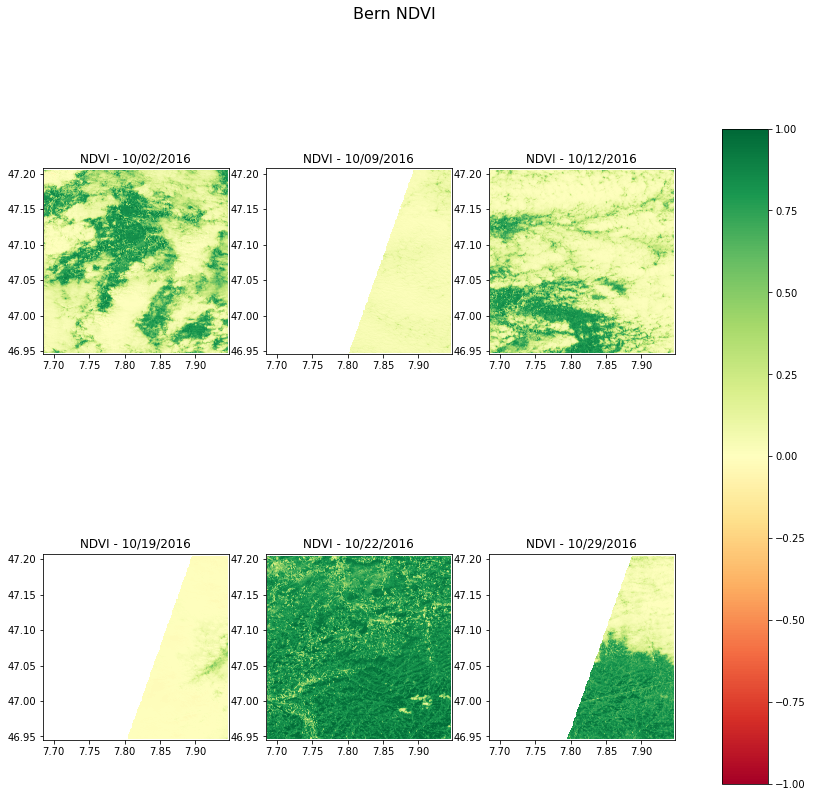

In [108]:
fig, axs = plt.subplots(2, 3, figsize=(13, 13))
im_10_02_16 = axs[0,0].imshow(query_bern_10_11_16.data[id_string_10_02_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_10_09_16 = axs[0,1].imshow(query_bern_10_11_16.data[id_string_10_09_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_10_12_16 = axs[0,2].imshow(query_bern_10_11_16.data[id_string_10_12_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_10_19_16 = axs[1,0].imshow(query_bern_10_11_16.data[id_string_10_19_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_10_22_16 = axs[1,1].imshow(query_bern_10_11_16.data[id_string_10_22_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_10_29_16 = axs[1,2].imshow(query_bern_10_11_16.data[id_string_10_29_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)

axs[0,0].set_title('NDVI - 10/02/2016')
axs[0,1].set_title('NDVI - 10/09/2016')
axs[0,2].set_title('NDVI - 10/12/2016')
axs[1,0].set_title('NDVI - 10/19/2016')
axs[1,1].set_title('NDVI - 10/22/2016')
axs[1,2].set_title('NDVI - 10/29/2016')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im_08_23_16, cax=cbar_ax)
fig.suptitle('Bern NDVI', fontsize=16)
plt.savefig('bern_2016_1011.jpg')
plt.show()

## 11/2016 - 12/2016

In [57]:
dates = {
    '20161101' : datetime(2016, 11, 1, 12).strftime(iso8601),
    '20161201' : datetime(2016, 12, 1, 12).strftime(iso8601)
}

In [58]:
query_bern_11_12_16_json = {
    'layers' : [
        {
            
            'type' : 'raster', 'id' : rgbNirNdviLayers[lKey],
            # 'temporal' : {'intervals' : [{'snapshot' : dates[dKey]}]},
            'temporal' : {'intervals' : [{'start' : list(dates.values())[0], 'end': list(dates.values())[1]}]},
            # 'output' : False
        }
        for lKey in rgbNirNdviLayers
    ],
    "spatial" : {"type" : "square",  "coordinates" : ["46.94599", "7.68597", "47.20599", "7.94597"] }, #Some area in Bern
    "temporal" : {"intervals" : [{ #this is redundant whne the temporal key is defined in layers! But still needed
        "start" : datetime(2016, 11, 1, 12).strftime(iso8601), "end" : datetime(2016, 12, 1, 12).strftime(iso8601)
        
    }
    ]}
}

In [59]:
query_bern_11_12_16 = paw.PAIRSQuery(query_bern_11_12_16_json, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query_bern_11_12_16.submit()

INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663214400_19296026


In [60]:
query_bern_11_12_16.poll_till_finished()
query_bern_11_12_16.download()
query_bern_11_12_16.create_layers()

INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663214400_19296026_0c5ae7885d3f66a388e9c9bfd6384823.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.


In [62]:
response_format = "%m_%d_%YT%H_%M_%S"
layers_11_12_16_df = pd.DataFrame([k.split("-") for k in query_bern_11_12_16.metadata], columns=["dataset", "band", "date"])
layers_11_12_16_df["pixelMin"] = [query_bern_11_12_16.metadata[k]["details"]["rasterStatistics"]["pixelMin"] for k in query_bern_11_12_16.metadata]
layers_11_12_16_df["pixelMax"] = [query_bern_11_12_16.metadata[k]["details"]["rasterStatistics"]["pixelMax"] for k in query_bern_11_12_16.metadata]
layers_11_12_16_df["layerKey"] = query_bern_11_12_16.metadata.keys()
layers_11_12_16_df["date"] = pd.to_datetime(layers_11_12_16_df["date"], format=response_format)
layers_11_12_16_df = layers_11_12_16_df.sort_values(by='date')
layers_11_12_16_df

dataset  \
12  High res  imagery (ESA Sentinel 2)   
1   High res  imagery (ESA Sentinel 2)   
6   High res  imagery (ESA Sentinel 2)   
26  High res  imagery (ESA Sentinel 2)   
11  High res  imagery (ESA Sentinel 2)   
20  High res  imagery (ESA Sentinel 2)   
25  High res  imagery (ESA Sentinel 2)   
7   High res  imagery (ESA Sentinel 2)   
8   High res  imagery (ESA Sentinel 2)   
13  High res  imagery (ESA Sentinel 2)   
21  High res  imagery (ESA Sentinel 2)   
16  High res  imagery (ESA Sentinel 2)   
15  High res  imagery (ESA Sentinel 2)   
14  High res  imagery (ESA Sentinel 2)   
3   High res  imagery (ESA Sentinel 2)   
28  High res  imagery (ESA Sentinel 2)   
9   High res  imagery (ESA Sentinel 2)   
17  High res  imagery (ESA Sentinel 2)   
27  High res  imagery (ESA Sentinel 2)   
2   High res  imagery (ESA Sentinel 2)   
5   High res  imagery (ESA Sentinel 2)   
19  High res  imagery (ESA Sentinel 2)   
22  High res  imagery (ESA Sentinel 2)   
23  High res  imagery (ESA Sentinel 2)   
24  High res  imagery (ESA Sentinel 2)   
0   High res  imagery (ESA Sentinel 2)   
10  High res  imagery (ESA Sentinel 2)   
4   High res  imagery (ESA Sentinel 2)   
18  High res  imagery (ESA Sentinel 2)   
29  High res  imagery (ESA Sentinel 2)   

                                      band       date  pixelMin  pixelMax  \
12  Normalized difference vegetation index 2016-11-08   -0.1514    0.7760   
1                             Band 4 (red) 2016-11-08    0.0188    1.4598   
6                             Band 8 (NIR) 2016-11-08    0.0999    1.5015   
26                           Band 2 (blue) 2016-11-08    0.0044    1.5232   
11                          Band 3 (green) 2016-11-08    0.0267    1.4729   
20                           Band 2 (blue) 2016-11-11    0.0001    1.8770   
25                            Band 8 (NIR) 2016-11-11    0.0001    1.6387   
7                             Band 4 (red) 2016-11-11    0.0001    1.7071   
8                           Band 3 (green) 2016-11-11    0.0001    1.7827   
13  Normalized difference vegetation index 2016-11-11   -0.9642    0.9995   
21                            Band 8 (NIR) 2016-11-18    0.5386    1.6449   
16                            Band 4 (red) 2016-11-18    0.5574    1.7197   
15  Normalized difference vegetation index 2016-11-18   -0.1459    0.1265   
14                           Band 2 (blue) 2016-11-18    0.6341    1.9147   
3                           Band 3 (green) 2016-11-18    0.6020    1.8008   
28  Normalized difference vegetation index 2016-11-21   -0.0210    0.1543   
9                            Band 2 (blue) 2016-11-21    0.3473    1.0884   
17                          Band 3 (green) 2016-11-21    0.2607    0.9740   
27                            Band 4 (red) 2016-11-21    0.2822    0.9476   
2                             Band 8 (NIR) 2016-11-21    0.3750    1.0000   
5                             Band 4 (red) 2016-11-28    0.0001    1.5822   
19                          Band 3 (green) 2016-11-28    0.0012    1.5661   
22                           Band 2 (blue) 2016-11-28    0.0001    1.5922   
23  Normalized difference vegetation index 2016-11-28   -0.2191    0.9912   
24                            Band 8 (NIR) 2016-11-28    0.0080    1.5548   
0                            Band 2 (blue) 2016-12-01    0.0001    1.7622   
10                            Band 8 (NIR) 2016-12-01    0.0002    1.5522   
4                           Band 3 (green) 2016-12-01    0.0001    1.6691   
18  Normalized difference vegetation index 2016-12-01   -0.8858    0.9993   
29                            Band 4 (red) 2016-12-01    0.0001    1.6097   

                                             layerKey  
12  High res  imagery (ESA Sentinel 2)-Normalized ...  
1   High res  imagery (ESA Sentinel 2)-Band 4 (red...  
6   High res  imagery (ESA Sentinel 2)-Band 8 (NIR...  
26  High res  imagery (ESA Sentinel 2)-Band 2 (blu...  
11  High res  imagery (ESA Sentinel 2)-Band 3 (gre...  
20  

In [63]:
query_metadata_11_12_16 = pd.DataFrame(query_bern_11_12_16.metadata).transpose()

id_string_11_08_16 = create_id_string(query_metadata_11_12_16,'49464','11-08-2016T00:00:00Z')
id_string_11_11_16 = create_id_string(query_metadata_11_12_16,'49464','11-11-2016T00:00:00Z')
id_string_11_18_16 = create_id_string(query_metadata_11_12_16,'49464','11-18-2016T00:00:00Z')
id_string_11_21_16 = create_id_string(query_metadata_11_12_16,'49464','11-21-2016T00:00:00Z')
id_string_11_28_16 = create_id_string(query_metadata_11_12_16,'49464','11-28-2016T00:00:00Z')

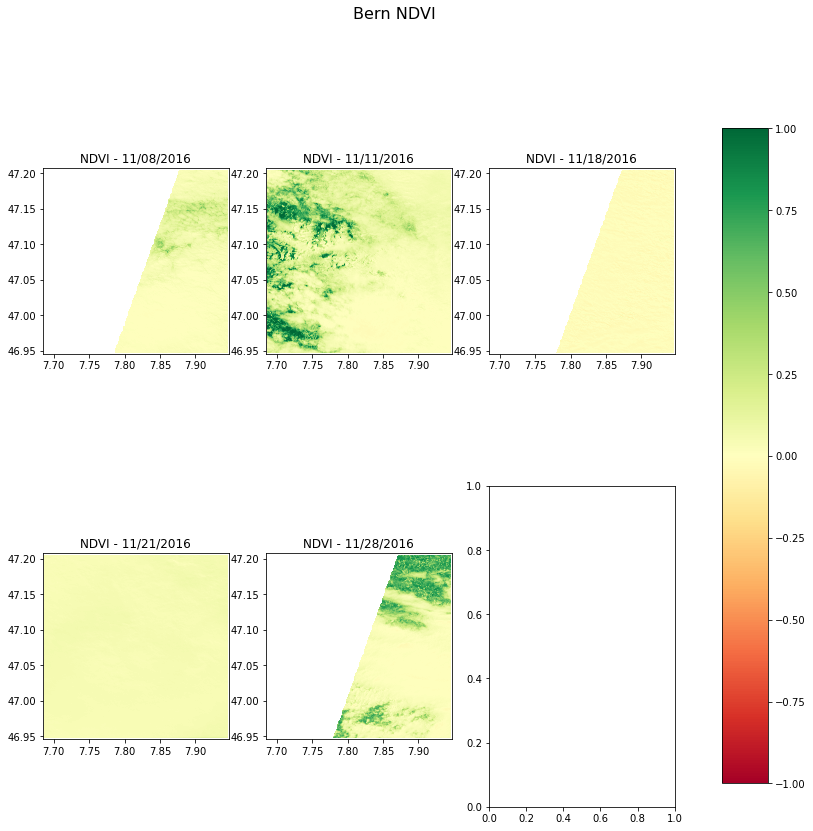

In [107]:
fig, axs = plt.subplots(2, 3, figsize=(13, 13))
im_10_02_16 = axs[0,0].imshow(query_bern_11_12_16.data[id_string_11_08_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_10_09_16 = axs[0,1].imshow(query_bern_11_12_16.data[id_string_11_11_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_10_12_16 = axs[0,2].imshow(query_bern_11_12_16.data[id_string_11_18_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_10_19_16 = axs[1,0].imshow(query_bern_11_12_16.data[id_string_11_21_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_10_22_16 = axs[1,1].imshow(query_bern_11_12_16.data[id_string_11_28_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)

axs[0,0].set_title('NDVI - 11/08/2016')
axs[0,1].set_title('NDVI - 11/11/2016')
axs[0,2].set_title('NDVI - 11/18/2016')
axs[1,0].set_title('NDVI - 11/21/2016')
axs[1,1].set_title('NDVI - 11/28/2016')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im_10_22_16, cax=cbar_ax)
fig.suptitle('Bern NDVI', fontsize=16)
plt.savefig('bern_2016_1112.jpg')
plt.show()

# Some area in Zurich
## 11/2015 - 12/2015

In [66]:
dates = {
    '20151101' : datetime(2015, 11, 1, 12).strftime(iso8601),
    '20151201' : datetime(2015, 12, 1, 12).strftime(iso8601)
}

In [69]:
query_zrh_11_12_15_json = {
    'layers' : [
        {
            
            'type' : 'raster', 'id' : rgbNirNdviLayers[lKey],
            # 'temporal' : {'intervals' : [{'snapshot' : dates[dKey]}]},
            'temporal' : {'intervals' : [{'start' : list(dates.values())[0], 'end': list(dates.values())[1]}]},
            # 'output' : False
        }
        for lKey in rgbNirNdviLayers
    ],
    "spatial" : {"type" : "square",  "coordinates" : ["47.3904", "8.0457", "47.6604", "8.3157"] }, #Some area in Zurich
    "temporal" : {"intervals" : [{ #this is redundant whne the temporal key is defined in layers! But still needed
        "start" : datetime(2015, 11, 1, 12).strftime(iso8601), "end" : datetime(2015, 12, 1, 12).strftime(iso8601)
        # "snapshot" : datetime(2021, 6, 13).strftime(iso8601),
    }
    ]}
}

In [72]:
query_zrh_11_12_15 = paw.PAIRSQuery(query_zrh_11_12_15_json, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query_zrh_11_12_15.submit()

INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663214400_20848007


In [73]:
query_zrh_11_12_15.poll_till_finished()
query_zrh_11_12_15.download()
query_zrh_11_12_15.create_layers()

INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663214400_20848007_09d126af97560a8318672fddcf648d63.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.


In [74]:
response_format = "%m_%d_%YT%H_%M_%S"
layers_zrh_11_12_15_df = pd.DataFrame([k.split("-") for k in query_zrh_11_12_15.metadata], columns=["dataset", "band", "date"])
layers_zrh_11_12_15_df["pixelMin"] = [query_zrh_11_12_15.metadata[k]["details"]["rasterStatistics"]["pixelMin"] for k in query_zrh_11_12_15.metadata]
layers_zrh_11_12_15_df["pixelMax"] = [query_zrh_11_12_15.metadata[k]["details"]["rasterStatistics"]["pixelMax"] for k in query_zrh_11_12_15.metadata]
layers_zrh_11_12_15_df["layerKey"] = query_zrh_11_12_15.metadata.keys()
layers_zrh_11_12_15_df["date"] = pd.to_datetime(layers_zrh_11_12_15_df["date"], format=response_format)
layers_zrh_11_12_15_df = layers_zrh_11_12_15_df.sort_values(by='date')
layers_zrh_11_12_15_df

dataset  \
0   High res  imagery (ESA Sentinel 2)   
13  High res  imagery (ESA Sentinel 2)   
12  High res  imagery (ESA Sentinel 2)   
5   High res  imagery (ESA Sentinel 2)   
11  High res  imagery (ESA Sentinel 2)   
15  High res  imagery (ESA Sentinel 2)   
14  High res  imagery (ESA Sentinel 2)   
18  High res  imagery (ESA Sentinel 2)   
9   High res  imagery (ESA Sentinel 2)   
6   High res  imagery (ESA Sentinel 2)   
7   High res  imagery (ESA Sentinel 2)   
3   High res  imagery (ESA Sentinel 2)   
2   High res  imagery (ESA Sentinel 2)   
16  High res  imagery (ESA Sentinel 2)   
19  High res  imagery (ESA Sentinel 2)   
10  High res  imagery (ESA Sentinel 2)   
4   High res  imagery (ESA Sentinel 2)   
1   High res  imagery (ESA Sentinel 2)   
17  High res  imagery (ESA Sentinel 2)   
8   High res  imagery (ESA Sentinel 2)   

                                      band       date  pixelMin  pixelMax  \
0                             Band 4 (red) 2015-11-14    0.0224    1.7374   
13                          Band 3 (green) 2015-11-14    0.0002    1.8348   
12                           Band 2 (blue) 2015-11-14    0.0052    1.9762   
5                             Band 8 (NIR) 2015-11-14    0.0308    1.6326   
11  Normalized difference vegetation index 2015-11-14   -0.8934    0.9368   
15                            Band 8 (NIR) 2015-11-17    0.1989    1.5990   
14  Normalized difference vegetation index 2015-11-17   -0.3031    0.3204   
18                          Band 3 (green) 2015-11-17    0.2102    1.7417   
9                             Band 4 (red) 2015-11-17    0.1932    1.6679   
6                            Band 2 (blue) 2015-11-17    0.2243    1.8449   
7                           Band 3 (green) 2015-11-24    0.0013    1.6677   
3                             Band 4 (red) 2015-11-24    0.0008    1.6111   
2                             Band 8 (NIR) 2015-11-24    0.0137    1.5508   
16                           Band 2 (blue) 2015-11-24    0.0001    1.7555   
19  Normalized difference vegetation index 2015-11-24   -0.4573    0.9797   
10  Normalized difference vegetation index 2015-11-27   -0.3954    0.8852   
4                            Band 2 (blue) 2015-11-27    0.0048    1.6974   
1                             Band 4 (red) 2015-11-27    0.0033    1.5946   
17                          Band 3 (green) 2015-11-27    0.0091    1.6379   
8                             Band 8 (NIR) 2015-11-27    0.0057    1.5559   

                                             layerKey  
0   High res  imagery (ESA Sentinel 2)-Band 4 (red...  
13  High res  imagery (ESA Sentinel 2)-Band 3 (gre...  
12  High res  imagery (ESA Sentinel 2)-Band 2 (blu...  
5   High res  imagery (ESA Sentinel 2)-Band 8 (NIR...  
11  High res  imagery (ESA Sentinel 2)-Normalized ...  
15  High res  imagery (ESA Sentinel 2)-Band 8 (NIR...  
14  High res  imagery (ESA Sentinel 2)-Normalized ...  
18  High res  imagery (ESA Sentinel 2)-Band 3 (gre...  
9   High res  imagery (ESA Sentinel 2)-Band 4 (red...  
6   High res  imagery (ESA Sentinel 2)-Band 2 (blu...  
7   High res  imagery (ESA Sentinel 2)-Band 3 (gre...  
3   High res  imagery (ESA Sentinel 2)-Band 4 (red...  
2   High res  imagery (ESA Sentinel 2)-Band 8 (NIR...  
16  High res  imagery (ESA Sentinel 2)-Band 2 (blu...  
19  High res  imagery (ESA Sentinel 2)-Normalized ...  
10  High res  imagery (ESA Sentinel 2)-Normalized ...  
4   High res  imagery (ESA Sentinel 2)-Band 2 (blu...  
1   High res  imagery (ESA Sentinel 2)-Band 4 (red...  
17  High res  imagery (ESA Sentinel 2)-Band 3 (gre...  
8   High res  imagery (ESA Sentinel 2)-Band 8 (NIR...

In [76]:
query_zrh_metadata_11_12_15 = pd.DataFrame(query_zrh_11_12_15.metadata).transpose()

id_string_11_14_15 = create_id_string(query_zrh_metadata_11_12_15,'49464','11-14-2015T00:00:00Z')
id_string_11_17_15 = create_id_string(query_zrh_metadata_11_12_15,'49464','11-17-2015T00:00:00Z')
id_string_11_24_15 = create_id_string(query_zrh_metadata_11_12_15,'49464','11-24-2015T00:00:00Z')
id_string_11_27_15 = create_id_string(query_zrh_metadata_11_12_15,'49464','11-27-2015T00:00:00Z')

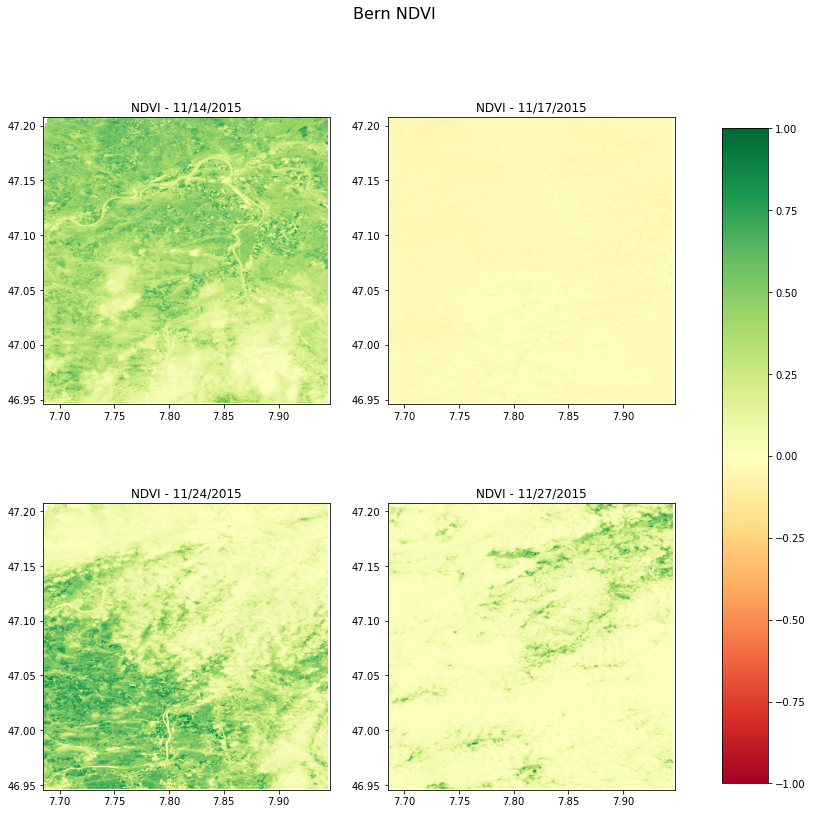

In [77]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13))
im_11_14_15 = axs[0,0].imshow(query_zrh_11_12_15.data[id_string_11_14_15], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_11_17_15 = axs[0,1].imshow(query_zrh_11_12_15.data[id_string_11_17_15], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_11_24_15 = axs[1,0].imshow(query_zrh_11_12_15.data[id_string_11_24_15], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_11_27_15 = axs[1,1].imshow(query_zrh_11_12_15.data[id_string_11_27_15], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)

axs[0,0].set_title('NDVI - 11/14/2015')
axs[0,1].set_title('NDVI - 11/17/2015')
axs[1,0].set_title('NDVI - 11/24/2015')
axs[1,1].set_title('NDVI - 11/27/2015')


cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im_10_22_16, cax=cbar_ax)
fig.suptitle('Bern NDVI', fontsize=16)
plt.savefig('zrh_2015_1112.jpg')
plt.show()

## Queries for 2016, Zurich

### Create Queries

In [17]:
#QUERY 1: 08/2016 - 09/2016

dates = {
    '20160801' : datetime(2016, 8, 1, 12).strftime(iso8601),
    '20160901' : datetime(2016, 9, 1, 12).strftime(iso8601)
}

query_zrh_08_09_16_json = {
    'layers' : [
        {
            
            'type' : 'raster', 'id' : rgbNirNdviLayers[lKey],
            # 'temporal' : {'intervals' : [{'snapshot' : dates[dKey]}]},
            'temporal' : {'intervals' : [{'start' : list(dates.values())[0], 'end': list(dates.values())[1]}]},
            # 'output' : False
        }
        for lKey in rgbNirNdviLayers
    ],
    "spatial" : {"type" : "square",  "coordinates" : ["47.3904", "8.0457", "47.6604", "8.3157"] }, #Some area in Zurich
    "temporal" : {"intervals" : [{ #this is redundant whne the temporal key is defined in layers! But still needed
        "start" : datetime(2016, 8, 1, 12).strftime(iso8601), "end" : datetime(2016, 9, 1, 12).strftime(iso8601)
        # "snapshot" : datetime(2021, 6, 13).strftime(iso8601),
    }
    ]}
}

In [8]:
#QUERY 2: 09/2016 - 10/2016

dates = {
    '20160901' : datetime(2016, 9, 1, 12).strftime(iso8601),
    '20161001' : datetime(2016, 10, 1, 12).strftime(iso8601)
}

query_zrh_09_10_16_json = {
    'layers' : [
        {
            
            'type' : 'raster', 'id' : rgbNirNdviLayers[lKey],
            # 'temporal' : {'intervals' : [{'snapshot' : dates[dKey]}]},
            'temporal' : {'intervals' : [{'start' : list(dates.values())[0], 'end': list(dates.values())[1]}]},
            # 'output' : False
        }
        for lKey in rgbNirNdviLayers
    ],
    "spatial" : {"type" : "square",  "coordinates" : ["47.3904", "8.0457", "47.6604", "8.3157"] }, #Some area in Zurich
    "temporal" : {"intervals" : [{ #this is redundant whne the temporal key is defined in layers! But still needed
        "start" : datetime(2016, 9, 1, 12).strftime(iso8601), "end" : datetime(2016, 10, 1, 12).strftime(iso8601)
        # "snapshot" : datetime(2021, 6, 13).strftime(iso8601),
    }
    ]}
}

In [79]:
#QUERY 3: 10/2016 - 11/2016

dates = {
    '20161001' : datetime(2016, 10, 1, 12).strftime(iso8601),
    '20161101' : datetime(2016, 11, 1, 12).strftime(iso8601)
}

query_zrh_10_11_16_json = {
    'layers' : [
        {
            
            'type' : 'raster', 'id' : rgbNirNdviLayers[lKey],
            # 'temporal' : {'intervals' : [{'snapshot' : dates[dKey]}]},
            'temporal' : {'intervals' : [{'start' : list(dates.values())[0], 'end': list(dates.values())[1]}]},
            # 'output' : False
        }
        for lKey in rgbNirNdviLayers
    ],
    "spatial" : {"type" : "square",  "coordinates" : ["47.3904", "8.0457", "47.6604", "8.3157"] }, #Some area in Zurich
    "temporal" : {"intervals" : [{ #this is redundant whne the temporal key is defined in layers! But still needed
        "start" : datetime(2016, 10, 1, 12).strftime(iso8601), "end" : datetime(2016, 11, 1, 12).strftime(iso8601)
        # "snapshot" : datetime(2021, 6, 13).strftime(iso8601),
    }
    ]}
}

In [96]:
#QUERY 4: 11/2016 - 12/2016

dates = {
    '20161101' : datetime(2016, 11, 1, 12).strftime(iso8601),
    '20161201' : datetime(2016, 12, 1, 12).strftime(iso8601)
}

query_zrh_11_12_16_json = {
    'layers' : [
        {
            
            'type' : 'raster', 'id' : rgbNirNdviLayers[lKey],
            # 'temporal' : {'intervals' : [{'snapshot' : dates[dKey]}]},
            'temporal' : {'intervals' : [{'start' : list(dates.values())[0], 'end': list(dates.values())[1]}]},
            # 'output' : False
        }
        for lKey in rgbNirNdviLayers
    ],
    "spatial" : {"type" : "square",  "coordinates" : ["47.3904", "8.0457", "47.6604", "8.3157"] }, #Some area in Zurich
    "temporal" : {"intervals" : [{ #this is redundant whne the temporal key is defined in layers! But still needed
        "start" : datetime(2016, 11, 1, 12).strftime(iso8601), "end" : datetime(2016, 12, 1, 12).strftime(iso8601)
        # "snapshot" : datetime(2021, 6, 13).strftime(iso8601),
    }
    ]}
}

### Submit the queries and download the result

In [18]:
query_zrh_08_09_16 = paw.PAIRSQuery(query_zrh_08_09_16_json, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query_zrh_08_09_16.submit()

INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663300800_14092870


In [81]:
#query_zrh_08_09_16 = paw.PAIRSQuery(query_zrh_08_09_16_json, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
#query_zrh_08_09_16.submit()

query_zrh_10_11_16 = paw.PAIRSQuery(query_zrh_10_11_16_json, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query_zrh_10_11_16.submit()

query_zrh_11_12_16 = paw.PAIRSQuery(query_zrh_11_12_16_json, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query_zrh_11_12_16.submit()

INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663214400_21769342
INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663214400_21770492
INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663214400_21771656


In [14]:
query_zrh_09_10_16 = paw.PAIRSQuery(query_zrh_09_10_16_json , PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query_zrh_09_10_16.submit()

INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663300800_13390718


In [19]:
query_zrh_08_09_16.poll_till_finished()
query_zrh_08_09_16.download()
query_zrh_08_09_16.create_layers()

INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663300800_14092870_6211b7357a0e152cf2420eb19e65af2b.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.


In [82]:
print('---- 08/09 2016 --------')
query_zrh_08_09_16.poll_till_finished()
query_zrh_08_09_16.download()
query_zrh_08_09_16.create_layers()
print('--------- DONE --------')

print('---- 10/11 2016 --------')
query_zrh_10_11_16.poll_till_finished()
query_zrh_10_11_16.download()
query_zrh_10_11_16.create_layers()
print('--------- DONE --------')

---- 08/09 2016 --------


INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663214400_21769342_6211b7357a0e152cf2420eb19e65af2b.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.


--------- DONE --------
---- 10/11 2016 --------


INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663214400_21770492_6a48d03974da02ed1c8d705c68f61a48.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.


--------- DONE --------
---- 11/12 2016 --------


ChunkedEncodingError: ("Connection broken: InvalidChunkLength(got length b'', 0 bytes read)", InvalidChunkLength(got length b'', 0 bytes read))

In [15]:
query_zrh_09_10_16.poll_till_finished()
query_zrh_09_10_16.download()
query_zrh_09_10_16.create_layers()

INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663300800_13390718_c3648b70756a39b6c0aa1ff70cc8a56a.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.


### Create dataframes from the data 08/2016 - 09/2016

In [20]:
response_format = "%m_%d_%YT%H_%M_%S"
layers_zrh_08_09_16_df = pd.DataFrame([k.split("-") for k in query_zrh_08_09_16.metadata], columns=["dataset", "band", "date"])
layers_zrh_08_09_16_df["pixelMin"] = [query_zrh_08_09_16.metadata[k]["details"]["rasterStatistics"]["pixelMin"] for k in query_zrh_08_09_16.metadata]
layers_zrh_08_09_16_df["pixelMax"] = [query_zrh_08_09_16.metadata[k]["details"]["rasterStatistics"]["pixelMax"] for k in query_zrh_08_09_16.metadata]
layers_zrh_08_09_16_df["layerKey"] = query_zrh_08_09_16.metadata.keys()
layers_zrh_08_09_16_df["date"] = pd.to_datetime(layers_zrh_08_09_16_df["date"], format=response_format)
layers_zrh_08_09_16_df = layers_zrh_08_09_16_df.sort_values(by='date')
layers_zrh_08_09_16_df

dataset  \
27  High res  imagery (ESA Sentinel 2)   
23  High res  imagery (ESA Sentinel 2)   
15  High res  imagery (ESA Sentinel 2)   
28  High res  imagery (ESA Sentinel 2)   
12  High res  imagery (ESA Sentinel 2)   
14  High res  imagery (ESA Sentinel 2)   
1   High res  imagery (ESA Sentinel 2)   
4   High res  imagery (ESA Sentinel 2)   
8   High res  imagery (ESA Sentinel 2)   
11  High res  imagery (ESA Sentinel 2)   
24  High res  imagery (ESA Sentinel 2)   
18  High res  imagery (ESA Sentinel 2)   
13  High res  imagery (ESA Sentinel 2)   
29  High res  imagery (ESA Sentinel 2)   
9   High res  imagery (ESA Sentinel 2)   
17  High res  imagery (ESA Sentinel 2)   
19  High res  imagery (ESA Sentinel 2)   
20  High res  imagery (ESA Sentinel 2)   
22  High res  imagery (ESA Sentinel 2)   
3   High res  imagery (ESA Sentinel 2)   
7   High res  imagery (ESA Sentinel 2)   
16  High res  imagery (ESA Sentinel 2)   
21  High res  imagery (ESA Sentinel 2)   
25  High res  imagery (ESA Sentinel 2)   
0   High res  imagery (ESA Sentinel 2)   
6   High res  imagery (ESA Sentinel 2)   
5   High res  imagery (ESA Sentinel 2)   
26  High res  imagery (ESA Sentinel 2)   
2   High res  imagery (ESA Sentinel 2)   
10  High res  imagery (ESA Sentinel 2)   

                                      band       date  pixelMin  pixelMax  \
27  Normalized difference vegetation index 2016-08-03   -0.1770    0.9095   
23                            Band 8 (NIR) 2016-08-03    0.0402    1.5482   
15                           Band 2 (blue) 2016-08-03    0.0027    1.7590   
28                          Band 3 (green) 2016-08-03    0.0217    1.6688   
12                            Band 4 (red) 2016-08-03    0.0137    1.6111   
14  Normalized difference vegetation index 2016-08-10   -0.9534    0.9912   
1                             Band 8 (NIR) 2016-08-10    0.0001    1.5630   
4                             Band 4 (red) 2016-08-10    0.0002    1.6404   
8                            Band 2 (blue) 2016-08-10    0.0001    1.8062   
11                          Band 3 (green) 2016-08-10    0.0003    1.7066   
24                          Band 3 (green) 2016-08-13    0.0002    1.6592   
18  Normalized difference vegetation index 2016-08-13   -0.7550    0.9954   
13                            Band 4 (red) 2016-08-13    0.0001    1.6023   
29                            Band 8 (NIR) 2016-08-13    0.0028    1.5445   
9                            Band 2 (blue) 2016-08-13    0.0001    1.7498   
17  Normalized difference vegetation index 2016-08-20   -0.0681    0.0937   
19                            Band 8 (NIR) 2016-08-20    0.8321    1.0794   
20                            Band 4 (red) 2016-08-20    0.8062    1.0491   
22                          Band 3 (green) 2016-08-20    0.7899    1.0502   
3                            Band 2 (blue) 2016-08-20    0.7514    1.0448   
7                             Band 8 (NIR) 2016-08-23    0.0001    1.5436   
16                            Band 4 (red) 2016-08-23    0.0001    1.6006   
21                           Band 2 (blue) 2016-08-23    0.0001    1.7467   
25  Normalized difference vegetation index 2016-08-23   -0.9874    0.9975   
0                           Band 3 (green) 2016-08-23    0.0001    1.6565   
6                            Band 2 (blue) 2016-08-30    0.0002    1.7806   
5                             Band 4 (red) 2016-08-30    0.0039    1.6236   
26  Normalized difference vegetation index 2016-08-30   -0.5656    0.9415   
2                           Band 3 (green) 2016-08-30    0.0057    1.6855   
10                            Band 8 (NIR) 2016-08-30    0.0091    1.5590   

                                             layerKey  
27  High res  imagery (ESA Sentinel 2)-Normalized ...  
23  High res  imagery (ESA Sentinel 2)-Band 8 (NIR...  
15  High res  imagery (ESA Sentinel 2)-Band 2 (blu...  
28  High res  imagery (ESA Sentinel 2)-Band 3 (gre...  
12  High res  imagery (ESA Sentinel 2)-Band 4 (red...  
14  

### Create the visualizations

In [25]:
query_zrh_metadata_08_09_16 = pd.DataFrame(query_zrh_08_09_16.metadata).transpose()
extent = [7.684864, 7.947008, 46.945664, 47.207808]
id_string_08_03_16 = create_id_string(query_zrh_metadata_08_09_16,'49464','08-03-2016T00:00:00Z')
id_string_08_10_16 = create_id_string(query_zrh_metadata_08_09_16,'49464','08-10-2016T00:00:00Z')
id_string_08_13_16 = create_id_string(query_zrh_metadata_08_09_16,'49464','08-13-2016T00:00:00Z')
id_string_08_20_16 = create_id_string(query_zrh_metadata_08_09_16,'49464','08-20-2016T00:00:00Z')
id_string_08_23_16 = create_id_string(query_zrh_metadata_08_09_16,'49464','08-23-2016T00:00:00Z')
id_string_08_30_16 = create_id_string(query_zrh_metadata_08_09_16,'49464','08-30-2016T00:00:00Z')

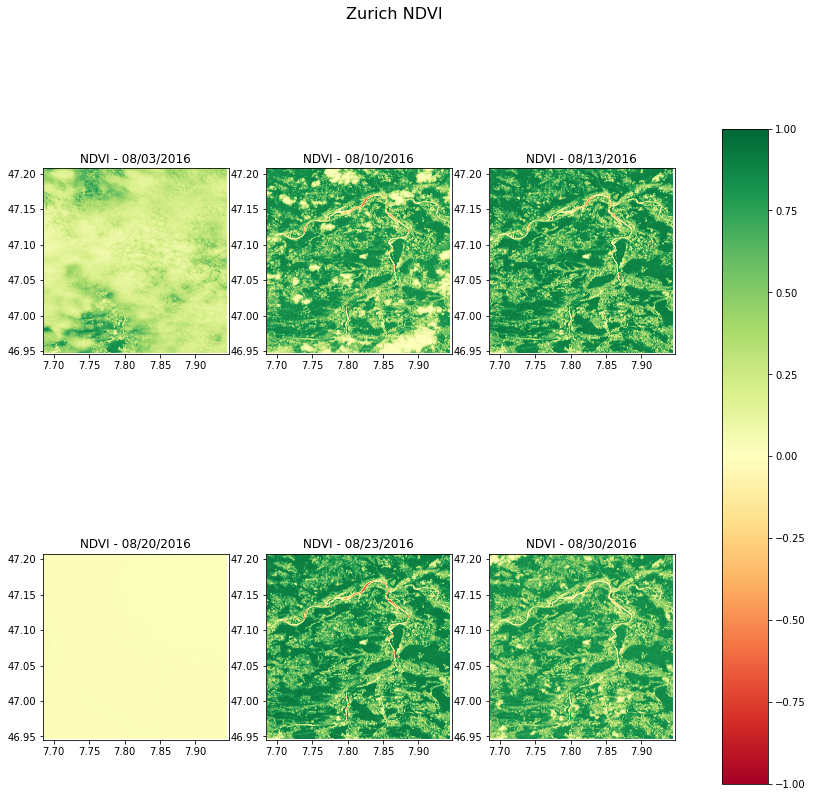

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(13, 13))
im_08_03_16 = axs[0,0].imshow(query_zrh_08_09_16.data[id_string_08_03_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_08_10_16 = axs[0,1].imshow(query_zrh_08_09_16.data[id_string_08_10_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_08_13_16 = axs[0,2].imshow(query_zrh_08_09_16.data[id_string_08_13_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_08_20_16 = axs[1,0].imshow(query_zrh_08_09_16.data[id_string_08_20_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_08_23_16 = axs[1,1].imshow(query_zrh_08_09_16.data[id_string_08_23_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_08_27_16 = axs[1,2].imshow(query_zrh_08_09_16.data[id_string_08_30_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)

axs[0,0].set_title('NDVI - 08/03/2016')
axs[0,1].set_title('NDVI - 08/10/2016')
axs[0,2].set_title('NDVI - 08/13/2016')
axs[1,0].set_title('NDVI - 08/20/2016')
axs[1,1].set_title('NDVI - 08/23/2016')
axs[1,2].set_title('NDVI - 08/30/2016')


cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im_08_27_16, cax=cbar_ax)
fig.suptitle('Zurich NDVI', fontsize=16)
plt.savefig('zrh_2016_0809.jpg')
plt.show()

### Create dataframes from the data 10/2016 - 11/2016

In [88]:
response_format = "%m_%d_%YT%H_%M_%S"
layers_zrh_10_11_16_df = pd.DataFrame([k.split("-") for k in query_zrh_10_11_16.metadata], columns=["dataset", "band", "date"])
layers_zrh_10_11_16_df["pixelMin"] = [query_zrh_10_11_16.metadata[k]["details"]["rasterStatistics"]["pixelMin"] for k in query_zrh_10_11_16.metadata]
layers_zrh_10_11_16_df["pixelMax"] = [query_zrh_10_11_16.metadata[k]["details"]["rasterStatistics"]["pixelMax"] for k in query_zrh_10_11_16.metadata]
layers_zrh_10_11_16_df["layerKey"] = query_zrh_10_11_16.metadata.keys()
layers_zrh_10_11_16_df["date"] = pd.to_datetime(layers_zrh_10_11_16_df["date"], format=response_format)
layers_zrh_10_11_16_df = layers_zrh_10_11_16_df.sort_values(by='date')
layers_zrh_10_11_16_df

dataset  \
17  High res  imagery (ESA Sentinel 2)   
31  High res  imagery (ESA Sentinel 2)   
30  High res  imagery (ESA Sentinel 2)   
29  High res  imagery (ESA Sentinel 2)   
16  High res  imagery (ESA Sentinel 2)   
28  High res  imagery (ESA Sentinel 2)   
24  High res  imagery (ESA Sentinel 2)   
7   High res  imagery (ESA Sentinel 2)   
8   High res  imagery (ESA Sentinel 2)   
13  High res  imagery (ESA Sentinel 2)   
27  High res  imagery (ESA Sentinel 2)   
18  High res  imagery (ESA Sentinel 2)   
15  High res  imagery (ESA Sentinel 2)   
0   High res  imagery (ESA Sentinel 2)   
10  High res  imagery (ESA Sentinel 2)   
32  High res  imagery (ESA Sentinel 2)   
3   High res  imagery (ESA Sentinel 2)   
20  High res  imagery (ESA Sentinel 2)   
21  High res  imagery (ESA Sentinel 2)   
22  High res  imagery (ESA Sentinel 2)   
6   High res  imagery (ESA Sentinel 2)   
33  High res  imagery (ESA Sentinel 2)   
9   High res  imagery (ESA Sentinel 2)   
4   High res  imagery (ESA Sentinel 2)   
5   High res  imagery (ESA Sentinel 2)   
14  High res  imagery (ESA Sentinel 2)   
12  High res  imagery (ESA Sentinel 2)   
11  High res  imagery (ESA Sentinel 2)   
25  High res  imagery (ESA Sentinel 2)   
34  High res  imagery (ESA Sentinel 2)   
26  High res  imagery (ESA Sentinel 2)   
23  High res  imagery (ESA Sentinel 2)   
19  High res  imagery (ESA Sentinel 2)   
2   High res  imagery (ESA Sentinel 2)   
1   High res  imagery (ESA Sentinel 2)   

                                      band       date  pixelMin  pixelMax  \
17                           Band 2 (blue) 2016-10-02    0.0002    1.7404   
31  Normalized difference vegetation index 2016-10-02   -0.7844    0.9466   
30                            Band 4 (red) 2016-10-02    0.0014    1.6085   
29                          Band 3 (green) 2016-10-02    0.0036    1.6615   
16                            Band 8 (NIR) 2016-10-02    0.0039    1.5536   
28  Normalized difference vegetation index 2016-10-09   -0.2294    0.6834   
24                          Band 3 (green) 2016-10-09    0.0998    1.3030   
7                            Band 2 (blue) 2016-10-09    0.0903    1.3509   
8                             Band 8 (NIR) 2016-10-09    0.1380    1.3092   
13                            Band 4 (red) 2016-10-09    0.0776    1.2981   
27  Normalized difference vegetation index 2016-10-12   -0.7134    0.9020   
18                          Band 3 (green) 2016-10-12    0.0045    1.6865   
15                            Band 4 (red) 2016-10-12    0.0030    1.6248   
0                            Band 2 (blue) 2016-10-12    0.0034    1.7806   
10                            Band 8 (NIR) 2016-10-12    0.0126    1.5619   
32                           Band 2 (blue) 2016-10-19    0.0001    1.8260   
3                             Band 4 (red) 2016-10-19    0.0001    1.6466   
20                            Band 8 (NIR) 2016-10-19    0.0001    1.5740   
21                          Band 3 (green) 2016-10-19    0.0016    1.7130   
22  Normalized difference vegetation index 2016-10-19   -0.9940    0.9954   
6                             Band 8 (NIR) 2016-10-22    0.0012    1.5571   
33                           Band 2 (blue) 2016-10-22    0.0001    1.7621   
9                           Band 3 (green) 2016-10-22    0.0001    1.6698   
4                             Band 4 (red) 2016-10-22    0.0001    1.6137   
5   Normalized difference vegetation index 2016-10-22   -0.5636    0.9960   
14                            Band 4 (red) 2016-10-29    0.0071    1.1010   
12  Normalized difference vegetation index 2016-10-29   -0.0690    0.8888   
11                            Band 8 (NIR) 2016-10-29    0.0230    1.0570   
25                          Band 3 (green) 2016-10-29    0.0169    1.1285   
34                           Band 2 (blue) 2016-10-29    0.0176    1.1597   
26  Normalized difference vegetation index 2016-11-01   -0.4417    0.9125   
23                            Band 8 (NIR) 2016-11-01 

In [90]:
query_zrh_metadata_10_11_16 = pd.DataFrame(query_zrh_10_11_16.metadata).transpose()

id_string_10_02_16 = create_id_string(query_zrh_metadata_10_11_16,'49464','10-02-2016T00:00:00Z')
id_string_10_09_16 = create_id_string(query_zrh_metadata_10_11_16,'49464','10-09-2016T00:00:00Z')
id_string_10_12_16 = create_id_string(query_zrh_metadata_10_11_16,'49464','10-12-2016T00:00:00Z')
id_string_10_19_16 = create_id_string(query_zrh_metadata_10_11_16,'49464','10-19-2016T00:00:00Z')
id_string_10_22_16 = create_id_string(query_zrh_metadata_10_11_16,'49464','10-22-2016T00:00:00Z')
id_string_10_29_16 = create_id_string(query_zrh_metadata_10_11_16,'49464','10-29-2016T00:00:00Z')

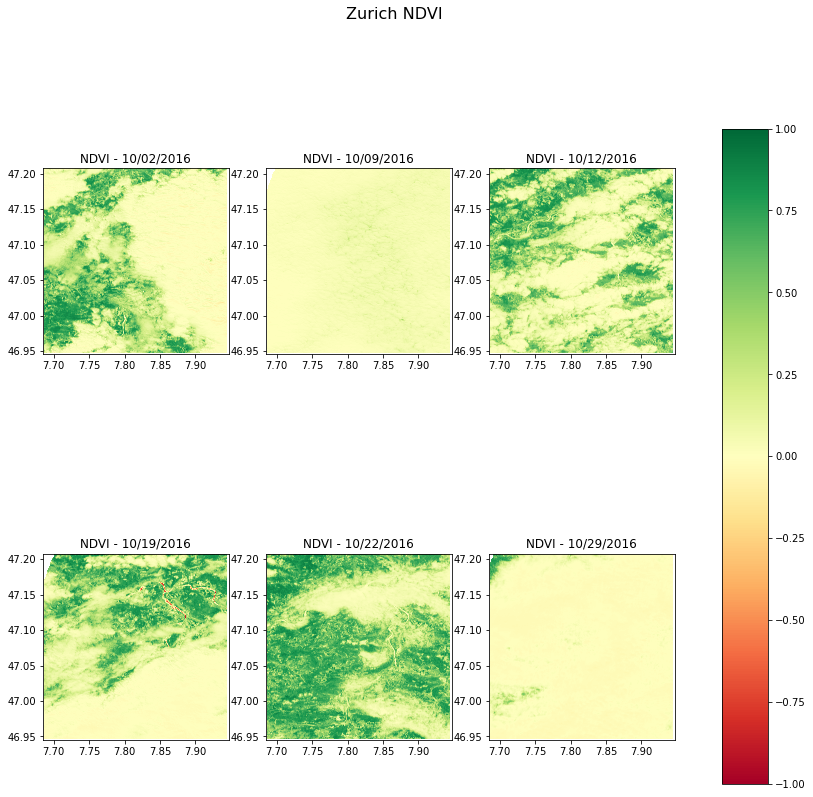

In [103]:
fig, axs = plt.subplots(2, 3, figsize=(13, 13))
im_10_02_16 = axs[0,0].imshow(query_zrh_10_11_16.data[id_string_10_02_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_10_09_16 = axs[0,1].imshow(query_zrh_10_11_16.data[id_string_10_09_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_10_12_16 = axs[0,2].imshow(query_zrh_10_11_16.data[id_string_10_12_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_10_19_16 = axs[1,0].imshow(query_zrh_10_11_16.data[id_string_10_19_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_10_22_16 = axs[1,1].imshow(query_zrh_10_11_16.data[id_string_10_22_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_10_29_16 = axs[1,2].imshow(query_zrh_10_11_16.data[id_string_10_29_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)

axs[0,0].set_title('NDVI - 10/02/2016')
axs[0,1].set_title('NDVI - 10/09/2016')
axs[0,2].set_title('NDVI - 10/12/2016')
axs[1,0].set_title('NDVI - 10/19/2016')
axs[1,1].set_title('NDVI - 10/22/2016')
axs[1,2].set_title('NDVI - 10/29/2016')


cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im_10_29_16, cax=cbar_ax)
fig.suptitle('Zurich NDVI', fontsize=16)
plt.savefig('zrh_2016_1011.jpg')
plt.show()

### 11/2016 - 12/2016

In [97]:
query_zrh_11_12_16 = paw.PAIRSQuery(query_zrh_11_12_16_json, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query_zrh_11_12_16.submit()

INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663214400_29062858


In [98]:
print('---- 11/12 2016 --------')
query_zrh_11_12_16.poll_till_finished()
query_zrh_11_12_16.download()
query_zrh_11_12_16.create_layers()
print('--------- DONE --------')

---- 11/12 2016 --------


INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663214400_29062858_bd9500bb3e19698cf403d7cd3fcd101b.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.


--------- DONE --------


### Create dataframes for 11/2016 - 12/2016

In [99]:
response_format = "%m_%d_%YT%H_%M_%S"
layers_zrh_11_12_16_df = pd.DataFrame([k.split("-") for k in query_zrh_11_12_16.metadata], columns=["dataset", "band", "date"])
layers_zrh_11_12_16_df["pixelMin"] = [query_zrh_11_12_16.metadata[k]["details"]["rasterStatistics"]["pixelMin"] for k in query_zrh_11_12_16.metadata]
layers_zrh_11_12_16_df["pixelMax"] = [query_zrh_11_12_16.metadata[k]["details"]["rasterStatistics"]["pixelMax"] for k in query_zrh_11_12_16.metadata]
layers_zrh_11_12_16_df["layerKey"] = query_zrh_11_12_16.metadata.keys()
layers_zrh_11_12_16_df["date"] = pd.to_datetime(layers_zrh_11_12_16_df["date"], format=response_format)
layers_zrh_11_12_16_df = layers_zrh_11_12_16_df.sort_values(by='date')
layers_zrh_11_12_16_df

dataset  \
16  High res  imagery (ESA Sentinel 2)   
2   High res  imagery (ESA Sentinel 2)   
12  High res  imagery (ESA Sentinel 2)   
11  High res  imagery (ESA Sentinel 2)   
24  High res  imagery (ESA Sentinel 2)   
28  High res  imagery (ESA Sentinel 2)   
10  High res  imagery (ESA Sentinel 2)   
26  High res  imagery (ESA Sentinel 2)   
6   High res  imagery (ESA Sentinel 2)   
23  High res  imagery (ESA Sentinel 2)   
5   High res  imagery (ESA Sentinel 2)   
9   High res  imagery (ESA Sentinel 2)   
19  High res  imagery (ESA Sentinel 2)   
4   High res  imagery (ESA Sentinel 2)   
1   High res  imagery (ESA Sentinel 2)   
17  High res  imagery (ESA Sentinel 2)   
18  High res  imagery (ESA Sentinel 2)   
0   High res  imagery (ESA Sentinel 2)   
21  High res  imagery (ESA Sentinel 2)   
20  High res  imagery (ESA Sentinel 2)   
22  High res  imagery (ESA Sentinel 2)   
14  High res  imagery (ESA Sentinel 2)   
3   High res  imagery (ESA Sentinel 2)   
15  High res  imagery (ESA Sentinel 2)   
29  High res  imagery (ESA Sentinel 2)   
13  High res  imagery (ESA Sentinel 2)   
8   High res  imagery (ESA Sentinel 2)   
7   High res  imagery (ESA Sentinel 2)   
25  High res  imagery (ESA Sentinel 2)   
27  High res  imagery (ESA Sentinel 2)   

                                      band       date  pixelMin  pixelMax  \
16                            Band 4 (red) 2016-11-08    0.1311    1.2047   
2                           Band 3 (green) 2016-11-08    0.1218    1.2333   
12  Normalized difference vegetation index 2016-11-08   -0.2079    0.3871   
11                           Band 2 (blue) 2016-11-08    0.1272    1.2993   
24                            Band 8 (NIR) 2016-11-08    0.1834    1.2403   
28                          Band 3 (green) 2016-11-11    0.0001    1.6464   
10                            Band 4 (red) 2016-11-11    0.0001    1.5628   
26                            Band 8 (NIR) 2016-11-11    0.0001    1.5412   
6                            Band 2 (blue) 2016-11-11    0.0001    1.7410   
23  Normalized difference vegetation index 2016-11-11   -0.4017    0.9991   
5   Normalized difference vegetation index 2016-11-18   -0.1508    0.1537   
9                           Band 3 (green) 2016-11-18    0.4748    1.7746   
19                           Band 2 (blue) 2016-11-18    0.5217    1.8753   
4                             Band 4 (red) 2016-11-18    0.4210    1.7015   
1                             Band 8 (NIR) 2016-11-18    0.4032    1.6333   
17                            Band 8 (NIR) 2016-11-21    0.4901    1.4296   
18                          Band 3 (green) 2016-11-21    0.4494    1.3793   
0                            Band 2 (blue) 2016-11-21    0.4229    1.3294   
21  Normalized difference vegetation index 2016-11-21   -0.0873    0.1604   
20                            Band 4 (red) 2016-11-21    0.4453    1.3441   
22  Normalized difference vegetation index 2016-11-28   -0.9907    0.9994   
14                          Band 3 (green) 2016-11-28    0.0001    1.6645   
3                            Band 2 (blue) 2016-11-28    0.0001    1.7579   
15                            Band 4 (red) 2016-11-28    0.0001    1.6046   
29                            Band 8 (NIR) 2016-11-28    0.0001    1.5518   
13                          Band 3 (green) 2016-12-01    0.0001    1.6675   
8                            Band 2 (blue) 2016-12-01    0.0001    1.7564   
7                             Band 8 (NIR) 2016-12-01    0.0001    1.5570   
25  Normalized difference vegetation index 2016-12-01   -0.8666    0.9987   
27                            Band 4 (red) 2016-12-01    0.0001    1.6082   

                                             layerKey  
16  High res  imagery (ESA Sentinel 2)-Band 4 (red...  
2   High res  imagery (ESA Sentinel 2)-Band 3 (gre...  
12  High res  imagery (ESA Sentinel 2)-Normalized ...  
11  High res  imagery (ESA Sentinel 2)-Band 2 (blu...  
24  High res  imagery (ESA Sentinel 2)-Band 8 (NIR...  
28  

### Create the visualizations

In [101]:
query_zrh_metadata_11_12_16 = pd.DataFrame(query_zrh_11_12_16.metadata).transpose()

id_string_11_08_16 = create_id_string(query_zrh_metadata_11_12_16,'49464','11-08-2016T00:00:00Z')
id_string_11_11_16 = create_id_string(query_zrh_metadata_11_12_16,'49464','11-11-2016T00:00:00Z')
id_string_11_18_16 = create_id_string(query_zrh_metadata_11_12_16,'49464','11-18-2016T00:00:00Z')
id_string_11_21_16 = create_id_string(query_zrh_metadata_11_12_16,'49464','11-21-2016T00:00:00Z')
id_string_11_28_16 = create_id_string(query_zrh_metadata_11_12_16,'49464','11-28-2016T00:00:00Z')

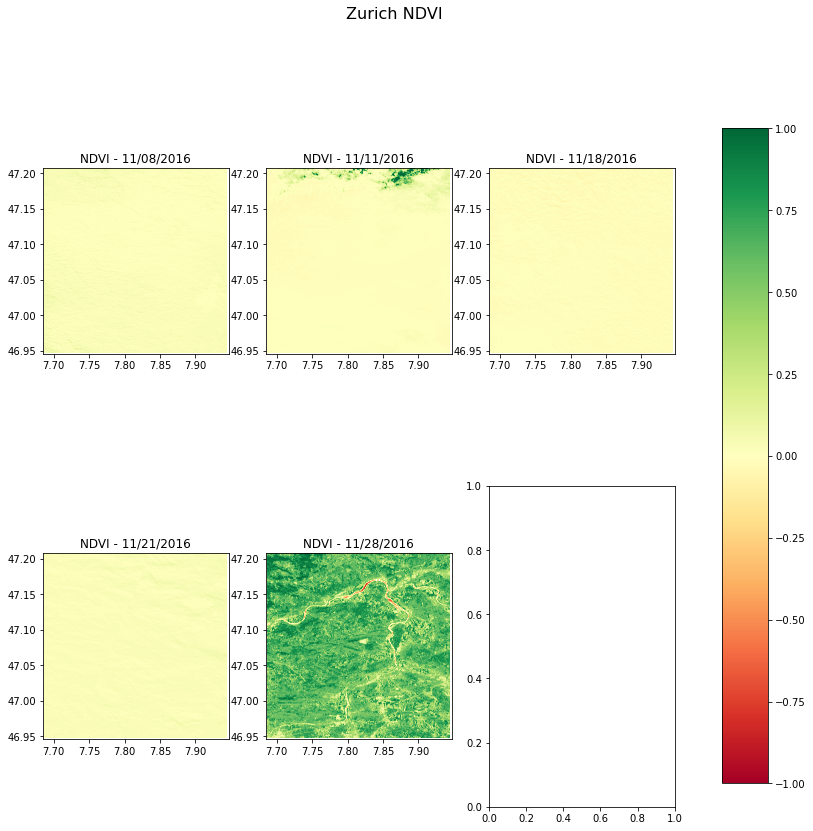

In [102]:
fig, axs = plt.subplots(2, 3, figsize=(13, 13))
im_11_08_16 = axs[0,0].imshow(query_zrh_11_12_16.data[id_string_11_08_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_11_11_16 = axs[0,1].imshow(query_zrh_11_12_16.data[id_string_11_11_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_11_18_16 = axs[0,2].imshow(query_zrh_11_12_16.data[id_string_11_18_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_11_21_16 = axs[1,0].imshow(query_zrh_11_12_16.data[id_string_11_21_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)
im_11_28_16 = axs[1,1].imshow(query_zrh_11_12_16.data[id_string_11_28_16], extent = extent,cmap = 'RdYlGn',vmin = -1,
                             vmax = 1)

axs[0,0].set_title('NDVI - 11/08/2016')
axs[0,1].set_title('NDVI - 11/11/2016')
axs[0,2].set_title('NDVI - 11/18/2016')
axs[1,0].set_title('NDVI - 11/21/2016')
axs[1,1].set_title('NDVI - 11/28/2016')


cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im_10_29_16, cax=cbar_ax)
fig.suptitle('Zurich NDVI', fontsize=16)
plt.savefig('zrh_2016_1112.jpg')
plt.show()